# MIT License

Copyright (c) 2022 Karan Raman Agrawal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



# Abstract:
This dataset about wine and its quality based on some features like alcohol content, suplphate, sugar, etc. It is used in wine industry to check the quality of wine.

# Aim: 
In this assignment we aim to create a complete ML project with 
- Checking Data Quality
- Feature Selection
- Modeling - Training Models, Selecting Best Model, Hyperparameter Tuning
- Model Interpretibility
- Reports and Visualizations


#Variable Description
1) **Fixed Acidity** - Quantity of non volatile acids in the wine.               
2) **Volatile Acidity** - Quantity of volatile acids like acetic acid in the wine.                                                                     
3) **Citric Acid** - Quantity of citric acid in wine, which gives sour taste to wine                                                             
4) **Residual Sugar** - Amount of sugar left in the wine after the process of fermentation                                                         
5) **Chlorides** - Quantity of salts in wine                               
6) **Free Sulphur dioxide** - Amount of free form of SO2, which prevents the oxidation of wine                                                 
7) **Total Sulphur dioxide** - Total Amount of SO2 - free and bonded in wine.    
8) **Density** - Density of wine       
9) **pH** - pH value of wine                          
10) **Sulphates** - Amount of sulphates in wine used as wine additive           
11) **Alcohol** - Quantity of alcohol on wine                                   
12) **Quality** - Output variable between (0 to 10)

In [ ]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o
!pip install fitter

import csv
import json
import logging
import optparse
import os
import random
import sys
import time
from datetime import datetime
from distutils.util import strtobool

# Importing all the libararies required for the assignment
import h2o
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from matplotlib.pyplot import figure

sns.set(rc={"figure.figsize": (16, 8)})

# Data Imputation
!pip install fancyimpute
from fancyimpute import IterativeImputer as MICE

# Model Interpretation
!pip install shap
import shap
from sklearn.model_selection import train_test_split

### What question are you trying to answer? How did you frame it as an ML task?

- Here I am trying to **predict the quality of wine** given some of its features like Alcohol, Sulphate, Sugar content. The quality of wine is denoted by numbers 3 to 8 where 3 is bad quality and 8 is the best. 
- The quality of wine is represented by a integer value from 3 to 8. This is a classical classification problem. But if we look at it as a purely classification problem, it may not be a fair play. E.g. Let's say that the predicted quality of wine is 7, but the actual quality was 8. In this case we came pretty close in predicting it's quality but as a purely classification problem, it is still a wrong prediction. Hence, another way is to approch this problem as a regression problem instead. 

### What is human-level performance on that task? What level of performance is needed?
- Sensory tests are performed by human taste experts which is a very complex and expensive process. This process is also nor very accurate as the wine testers are testing alot of wines which introduces a human bias. In this method we have taken 11 features of wine which can easily and quickly predict the quality of wine without little to none human interference, saving both money and time and giving a very accurate prediction

In [ ]:
# Reading Data into Pandas Dataframe
wine_df_pandas = pd.read_csv(
    "https://github.com/KaranAgrawal1509/DataScienceMethodsAndTools/raw/main/Wine_QT.csv"
)  # Reading CSV file into Pandas DataFrame

In [ ]:
wine_df_pandas.head()
wine_df_pandas = wine_df_pandas.drop(["Id"], axis=1)

### Where did the feature data and label come from?

- I used the Wine Quality Dataset from the UCI machine learning repository. The dataset contains 1143 different wine examples levels of the eleven physicochemical properties were determined: 
    - fixed acidity (g(tartaric acid)/L), 
    - volatile acidity (g(acetic acid)/L), 
    - citric acid (g/L), 
    - residual sugar (g/L), 
    - chlorides(g(sodium chloride)/L), 
    - free sulfur dioxide (mg/L), 
    - total sulfur dioxide (mg/L), 
    - density (g/ml), 
    - pH , 
    - sulphates (g(potassium sulphate)/L), 
    - alcohol ( % vol.).
    - The quality of the wines is a score between 3 and 8.


# Exploratory Data Analysis

In [ ]:
# Checking Data Type of each variable
wine_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1143 non-null   float64
 1   volatile_acidity      1143 non-null   float64
 2   citric_acid           1143 non-null   float64
 3   residual_sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free_sulfur_dioxide   1143 non-null   float64
 6   total_sulfur_dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [ ]:
# Checking for any null values in the dataset, as we hav no null values - we are good to go.
wine_df_pandas.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
# Shape of the dataframe - Here, we have 1143 samples of data with 12 predictors and 1 result
wine_df_pandas.shape

(1143, 12)

In [ ]:
columns = list(wine_df_pandas.columns)
print(columns)  # Name of all predictors and result

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


          sumsquare_error         aic          bic  kl_div
lognorm          0.282317  678.293554 -9472.788689     inf
chi2             0.299474  686.607150 -9405.354595     inf
gamma            0.299475  686.607061 -9405.353280     inf
cauchy           0.345093  681.612823 -9250.335602     inf
rayleigh         0.408070  649.164240 -9058.741008     inf


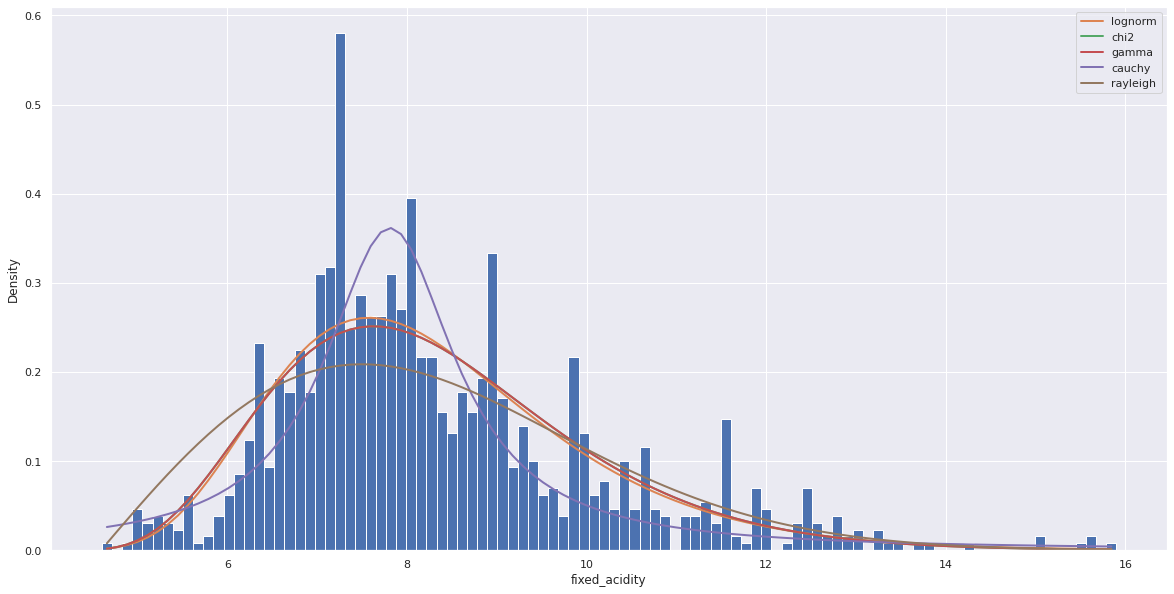

          sumsquare_error         aic          bic  kl_div
chi2            16.189125  440.245925 -4844.709025     inf
gamma           16.189127  440.246068 -4844.708847     inf
lognorm         16.332038  424.769135 -4834.663216     inf
norm            16.567258  710.219431 -4825.360095     inf
rayleigh        20.320648  371.282388 -4591.949012     inf


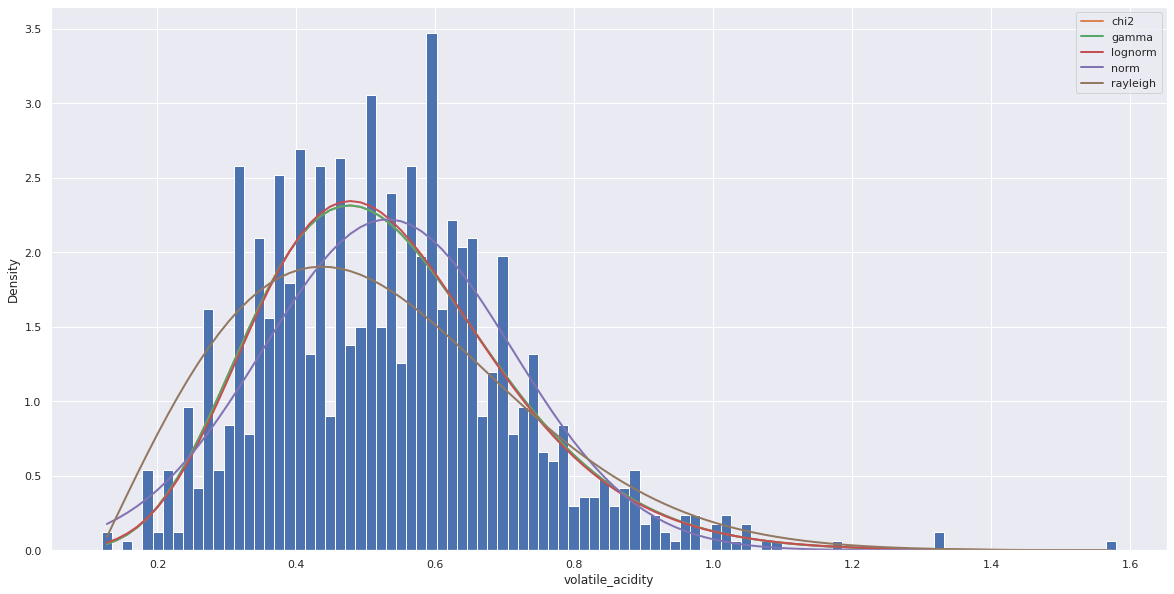

          sumsquare_error         aic          bic  kl_div
powerlaw        62.234366   47.153336 -3305.582183     inf
exponpow        67.951041  141.976736 -3205.135233     inf
expon           84.698511  113.546048 -2960.361667     inf
gamma           94.673607  163.501381 -2826.061788     inf
rayleigh        99.797078  163.579121 -2772.862944     inf


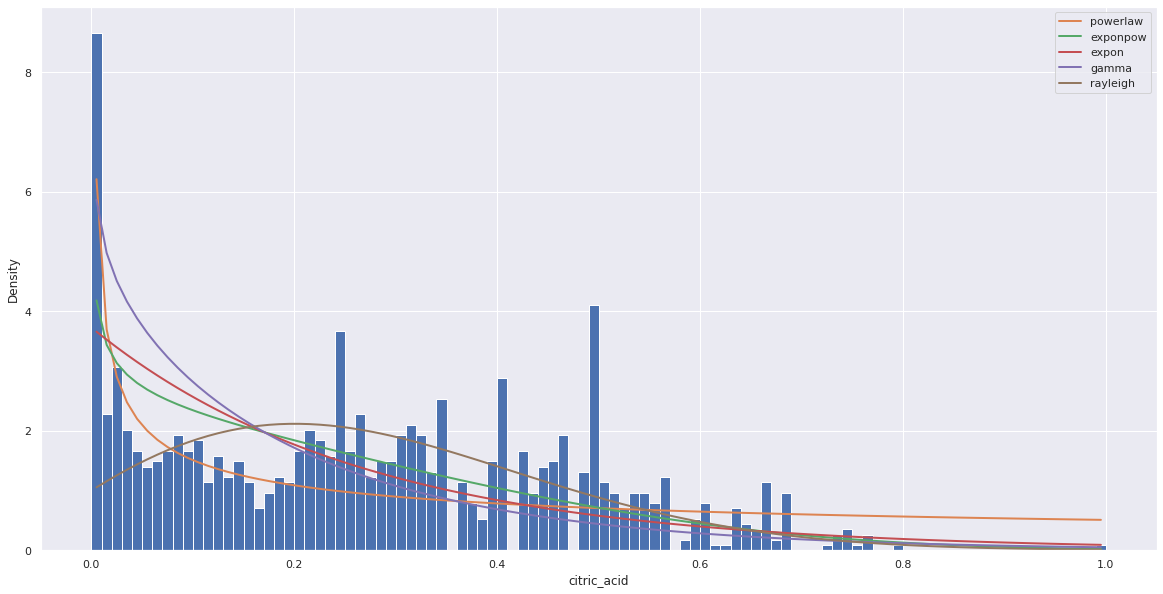

          sumsquare_error          aic          bic  kl_div
cauchy           0.518801  1050.559106 -8784.326545     inf
lognorm          0.759073  1375.833145 -8342.286267     inf
chi2             1.098216  1761.019465 -7920.124538     inf
rayleigh         1.670114  2723.384663 -7448.015505     inf
norm             2.079499  2964.364552 -7197.429327     inf


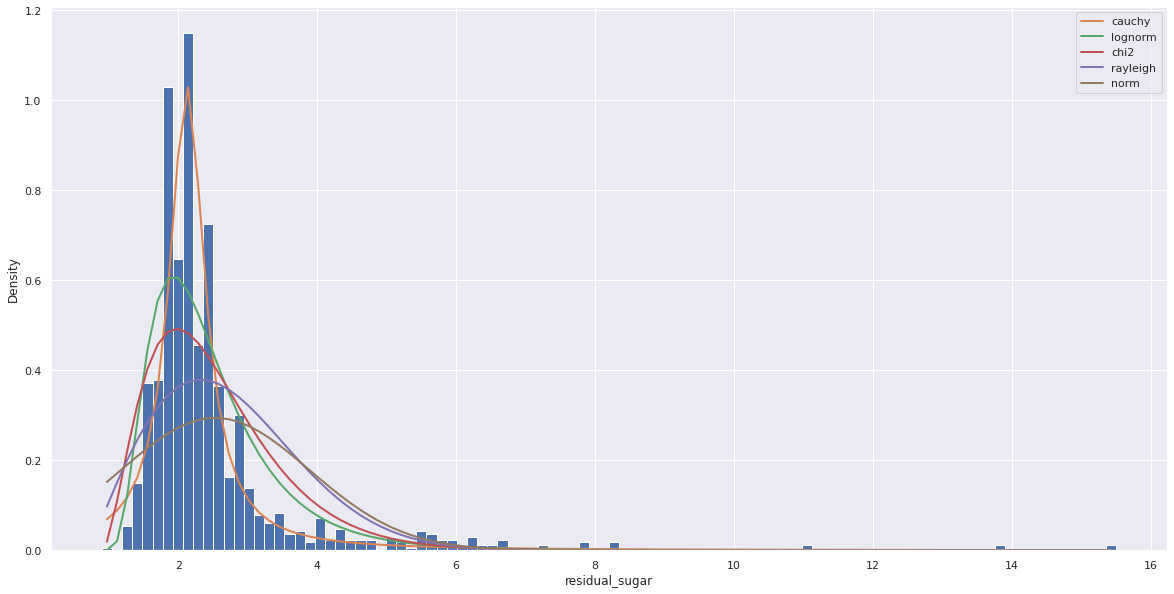

          sumsquare_error          aic          bic  kl_div
cauchy          71.952969   447.308356 -3146.768192     inf
lognorm        513.168095  1380.419177  -894.199539     inf
chi2           708.492425  1893.760583  -525.541000     inf
rayleigh      1193.468991  2226.945575    63.469339     inf
norm          1363.155302  3175.822130   215.417362     inf


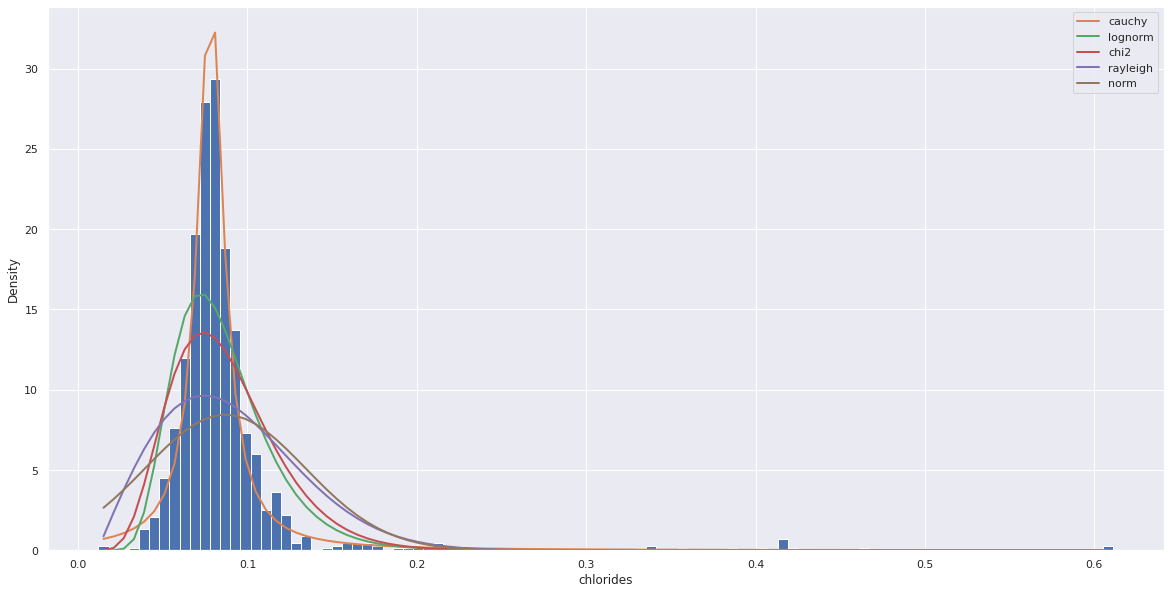

          sumsquare_error          aic           bic  kl_div
chi2             0.034126  1083.574728 -11887.906252     inf
gamma            0.034126  1083.572118 -11887.905306     inf
lognorm          0.034476  1052.601577 -11876.240267     inf
rayleigh         0.038287  1241.773515 -11763.453709     inf
norm             0.041621  1349.171169 -11668.032123     inf


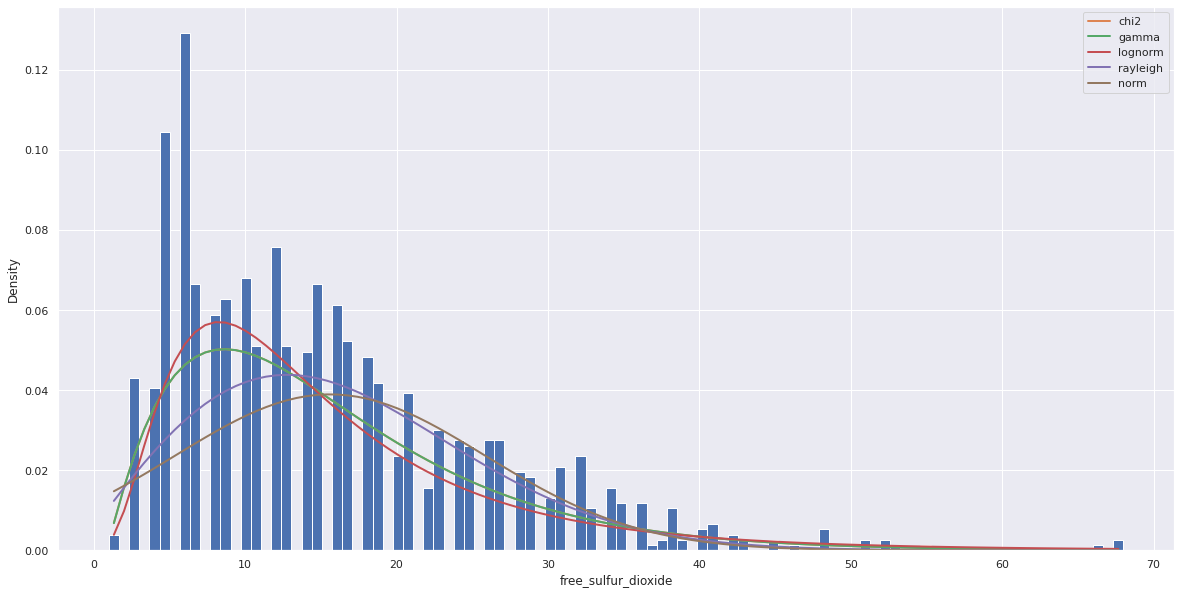

          sumsquare_error          aic           bic  kl_div
gamma            0.000294  1573.876081 -17322.314074     inf
lognorm          0.000305  1460.024034 -17280.643635     inf
exponpow         0.000721  1889.871688 -16296.899154     inf
expon            0.000763  1450.360927 -16238.634179     inf
rayleigh         0.000851  2167.624198 -16114.592302     inf


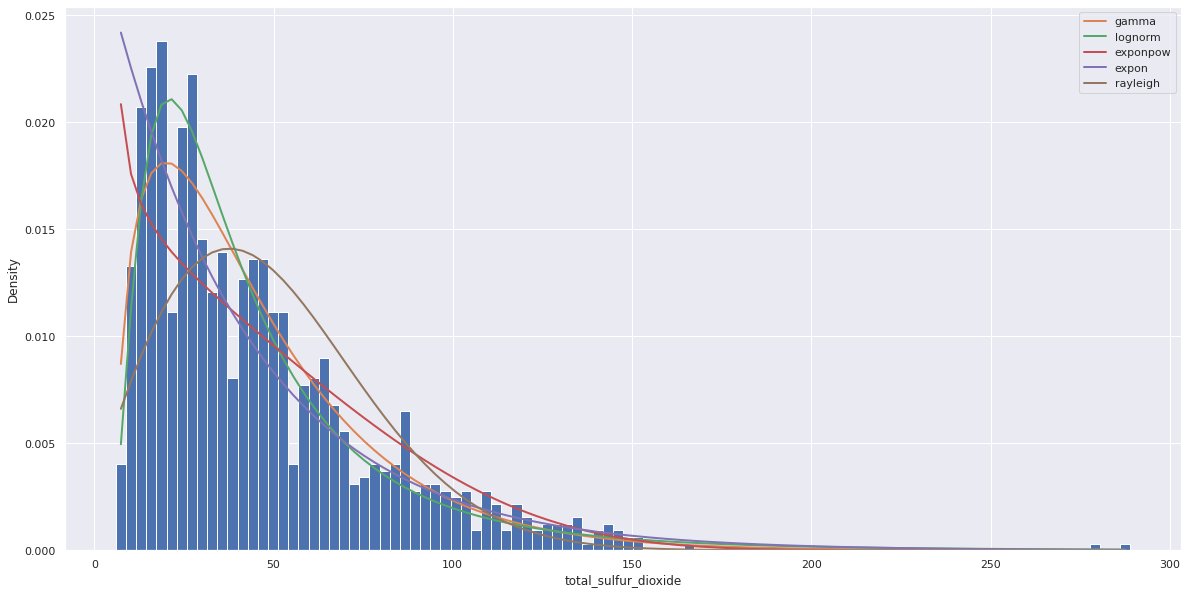

          sumsquare_error         aic          bic  kl_div
lognorm     102329.821618 -642.949703  5158.388892     inf
gamma       102380.387314 -643.105925  5158.953560     inf
norm        103564.475548 -644.791441  5165.055741     inf
cauchy      144477.356406 -699.361665  5545.592927     inf
rayleigh    431597.375547 -807.824728  6796.458249     inf


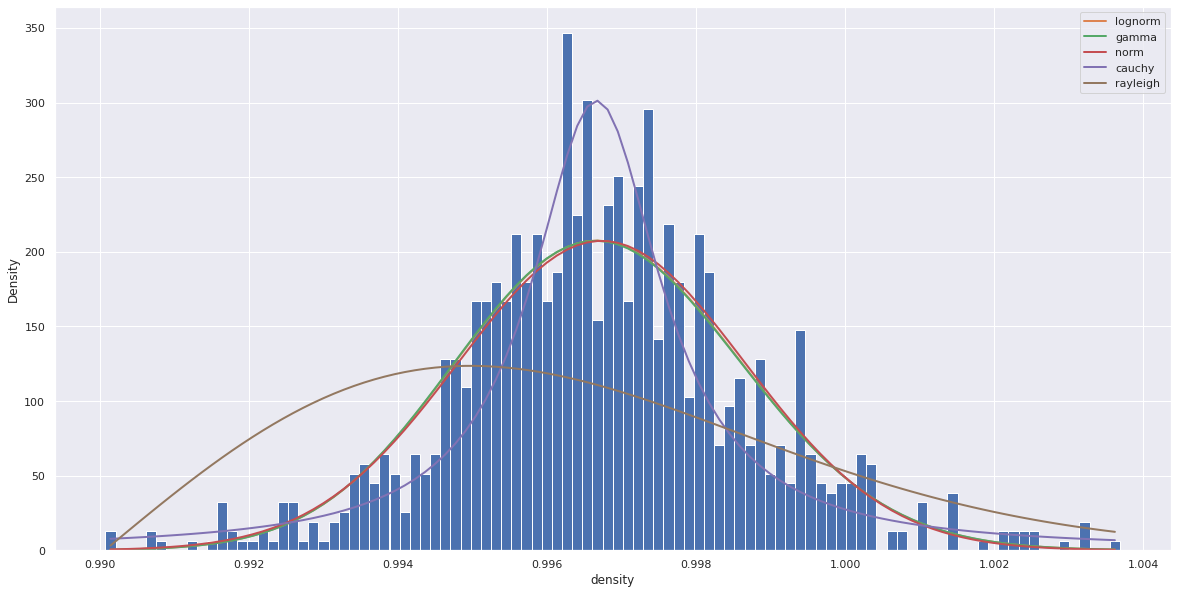

         sumsquare_error         aic          bic  kl_div
lognorm        31.102837  368.045508 -4098.376503     inf
gamma          31.110760  369.307168 -4098.085360     inf
norm           31.169029  381.720369 -4102.987989     inf
chi2           31.457147  363.517020 -4085.429527     inf
cauchy         40.334959  219.572066 -3808.329885     inf


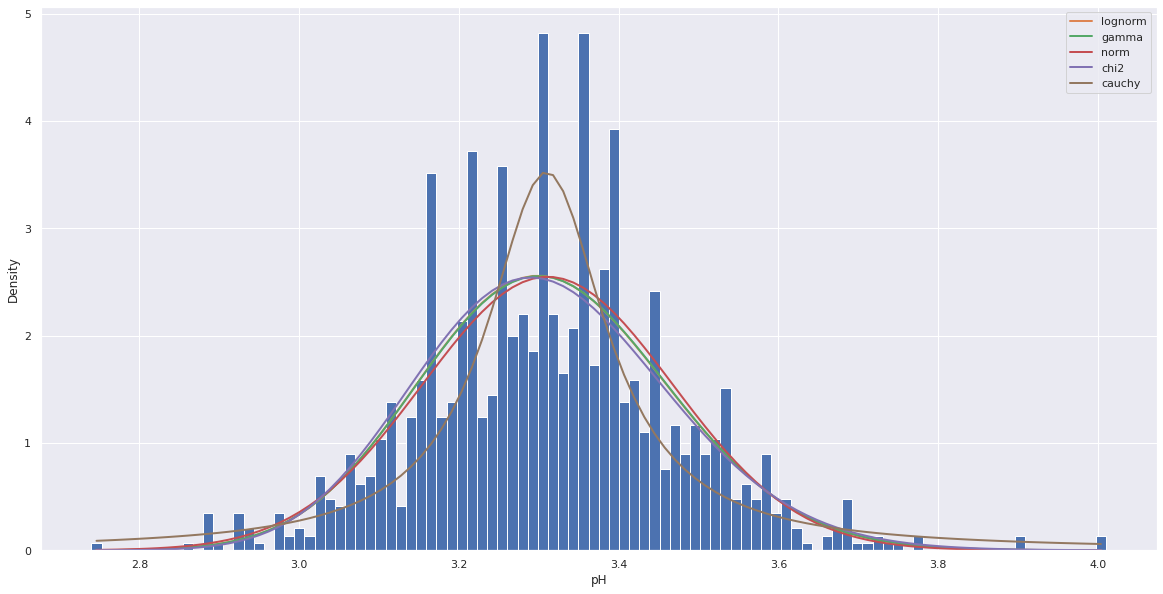

          sumsquare_error          aic          bic  kl_div
lognorm         16.582935   646.171436 -4817.237659     inf
gamma           19.515122   808.447413 -4631.139506     inf
cauchy          22.393052   435.916575 -4480.948626     inf
rayleigh        30.821149   923.243236 -4115.816845     inf
norm            35.824969  1521.902468 -3943.859343     inf


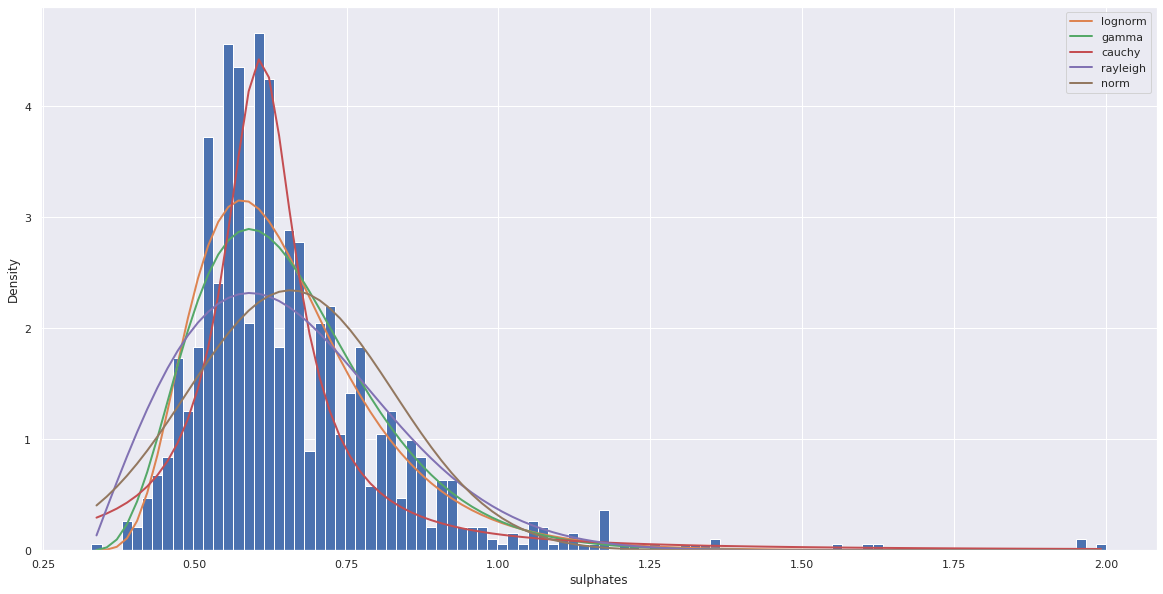

          sumsquare_error         aic          bic  kl_div
lognorm          3.574221  543.267651 -6571.316108     inf
gamma            3.643868  548.112632 -6549.258146     inf
rayleigh         3.772697  549.930504 -6516.586691     inf
norm             4.170972  629.050185 -6401.876184     inf
cauchy           4.305494  557.052952 -6365.594163     inf


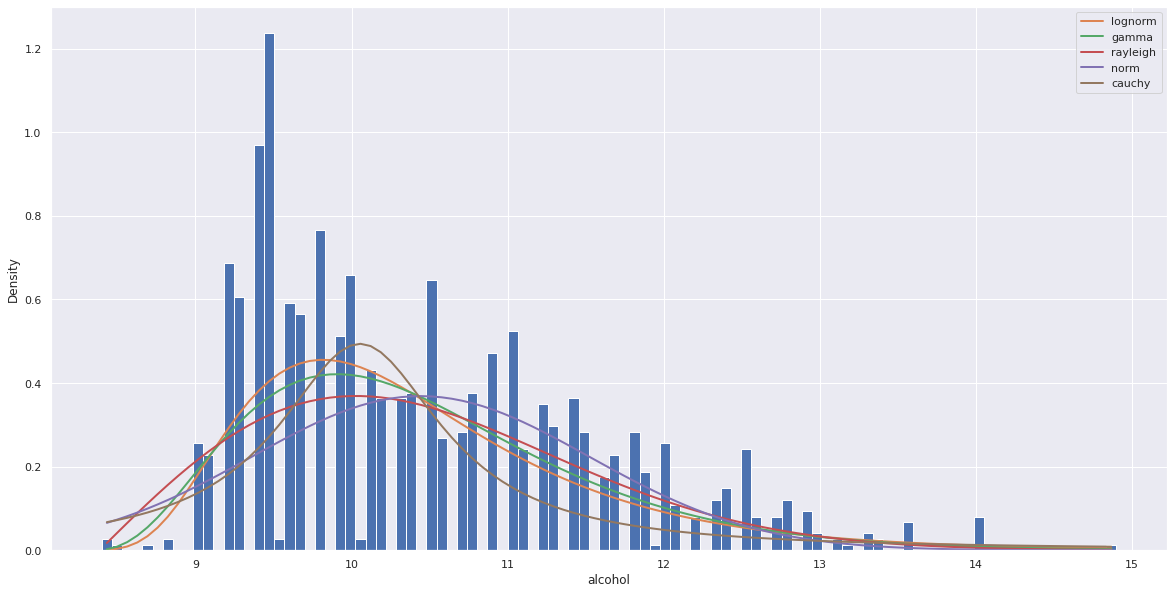

          sumsquare_error         aic          bic  kl_div
chi2           136.315637  503.422504 -2409.395091     inf
lognorm        136.360501  491.483161 -2409.018976     inf
gamma          136.363912  490.033263 -2408.990383     inf
norm           136.433731  469.404728 -2415.446718     inf
exponpow       136.895546  418.884285 -2404.542897     inf


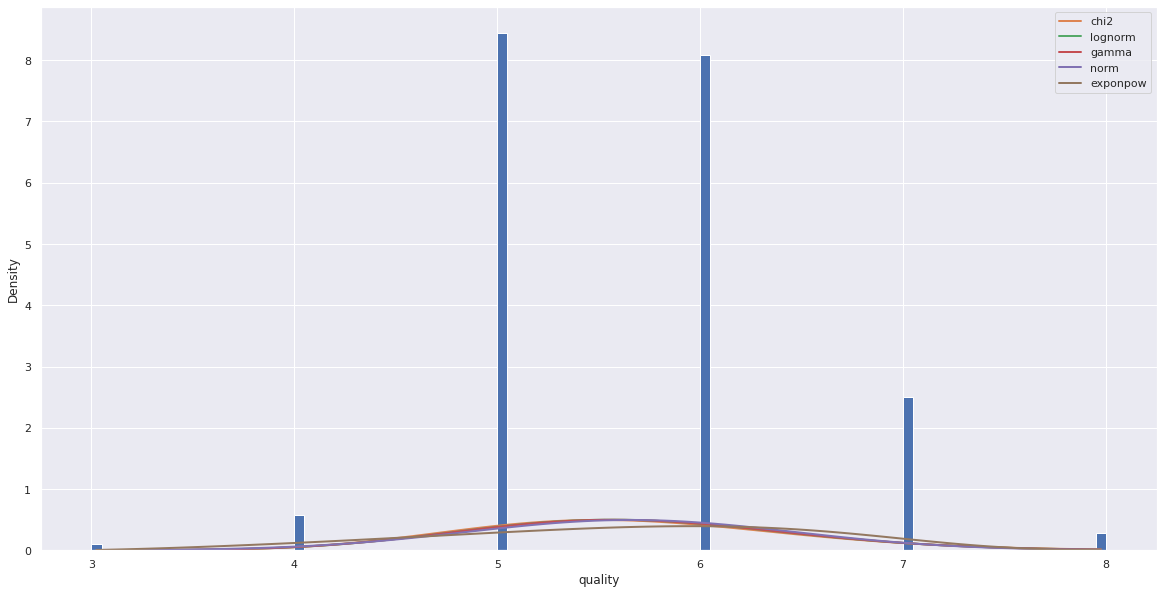

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)
for i in wine_df_pandas.columns:
    values = wine_df_pandas[i].values
    f = Fitter(values, distributions=get_common_distributions())
    f.fit()
    print(f.summary())
    plt.ylabel("Density")
    plt.xlabel(i)
    plt.show()

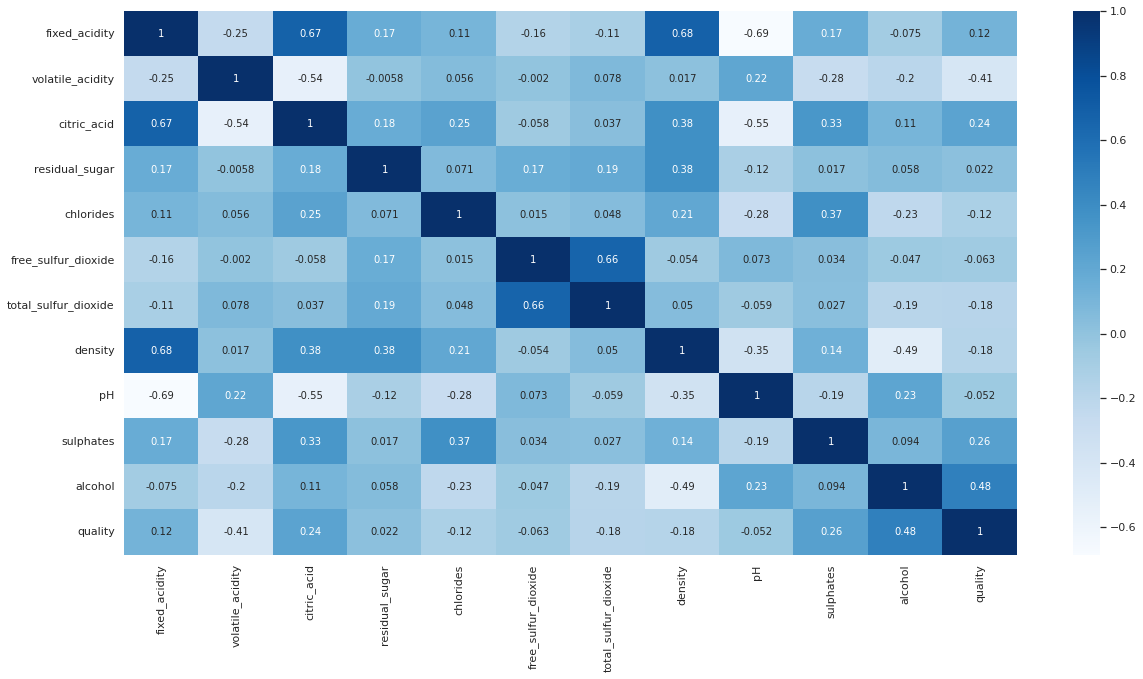

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)
sns.heatmap(
    wine_df_pandas.corr(), annot=True, cmap="Blues"
)  # Heatmap showing correlation between the attributes.

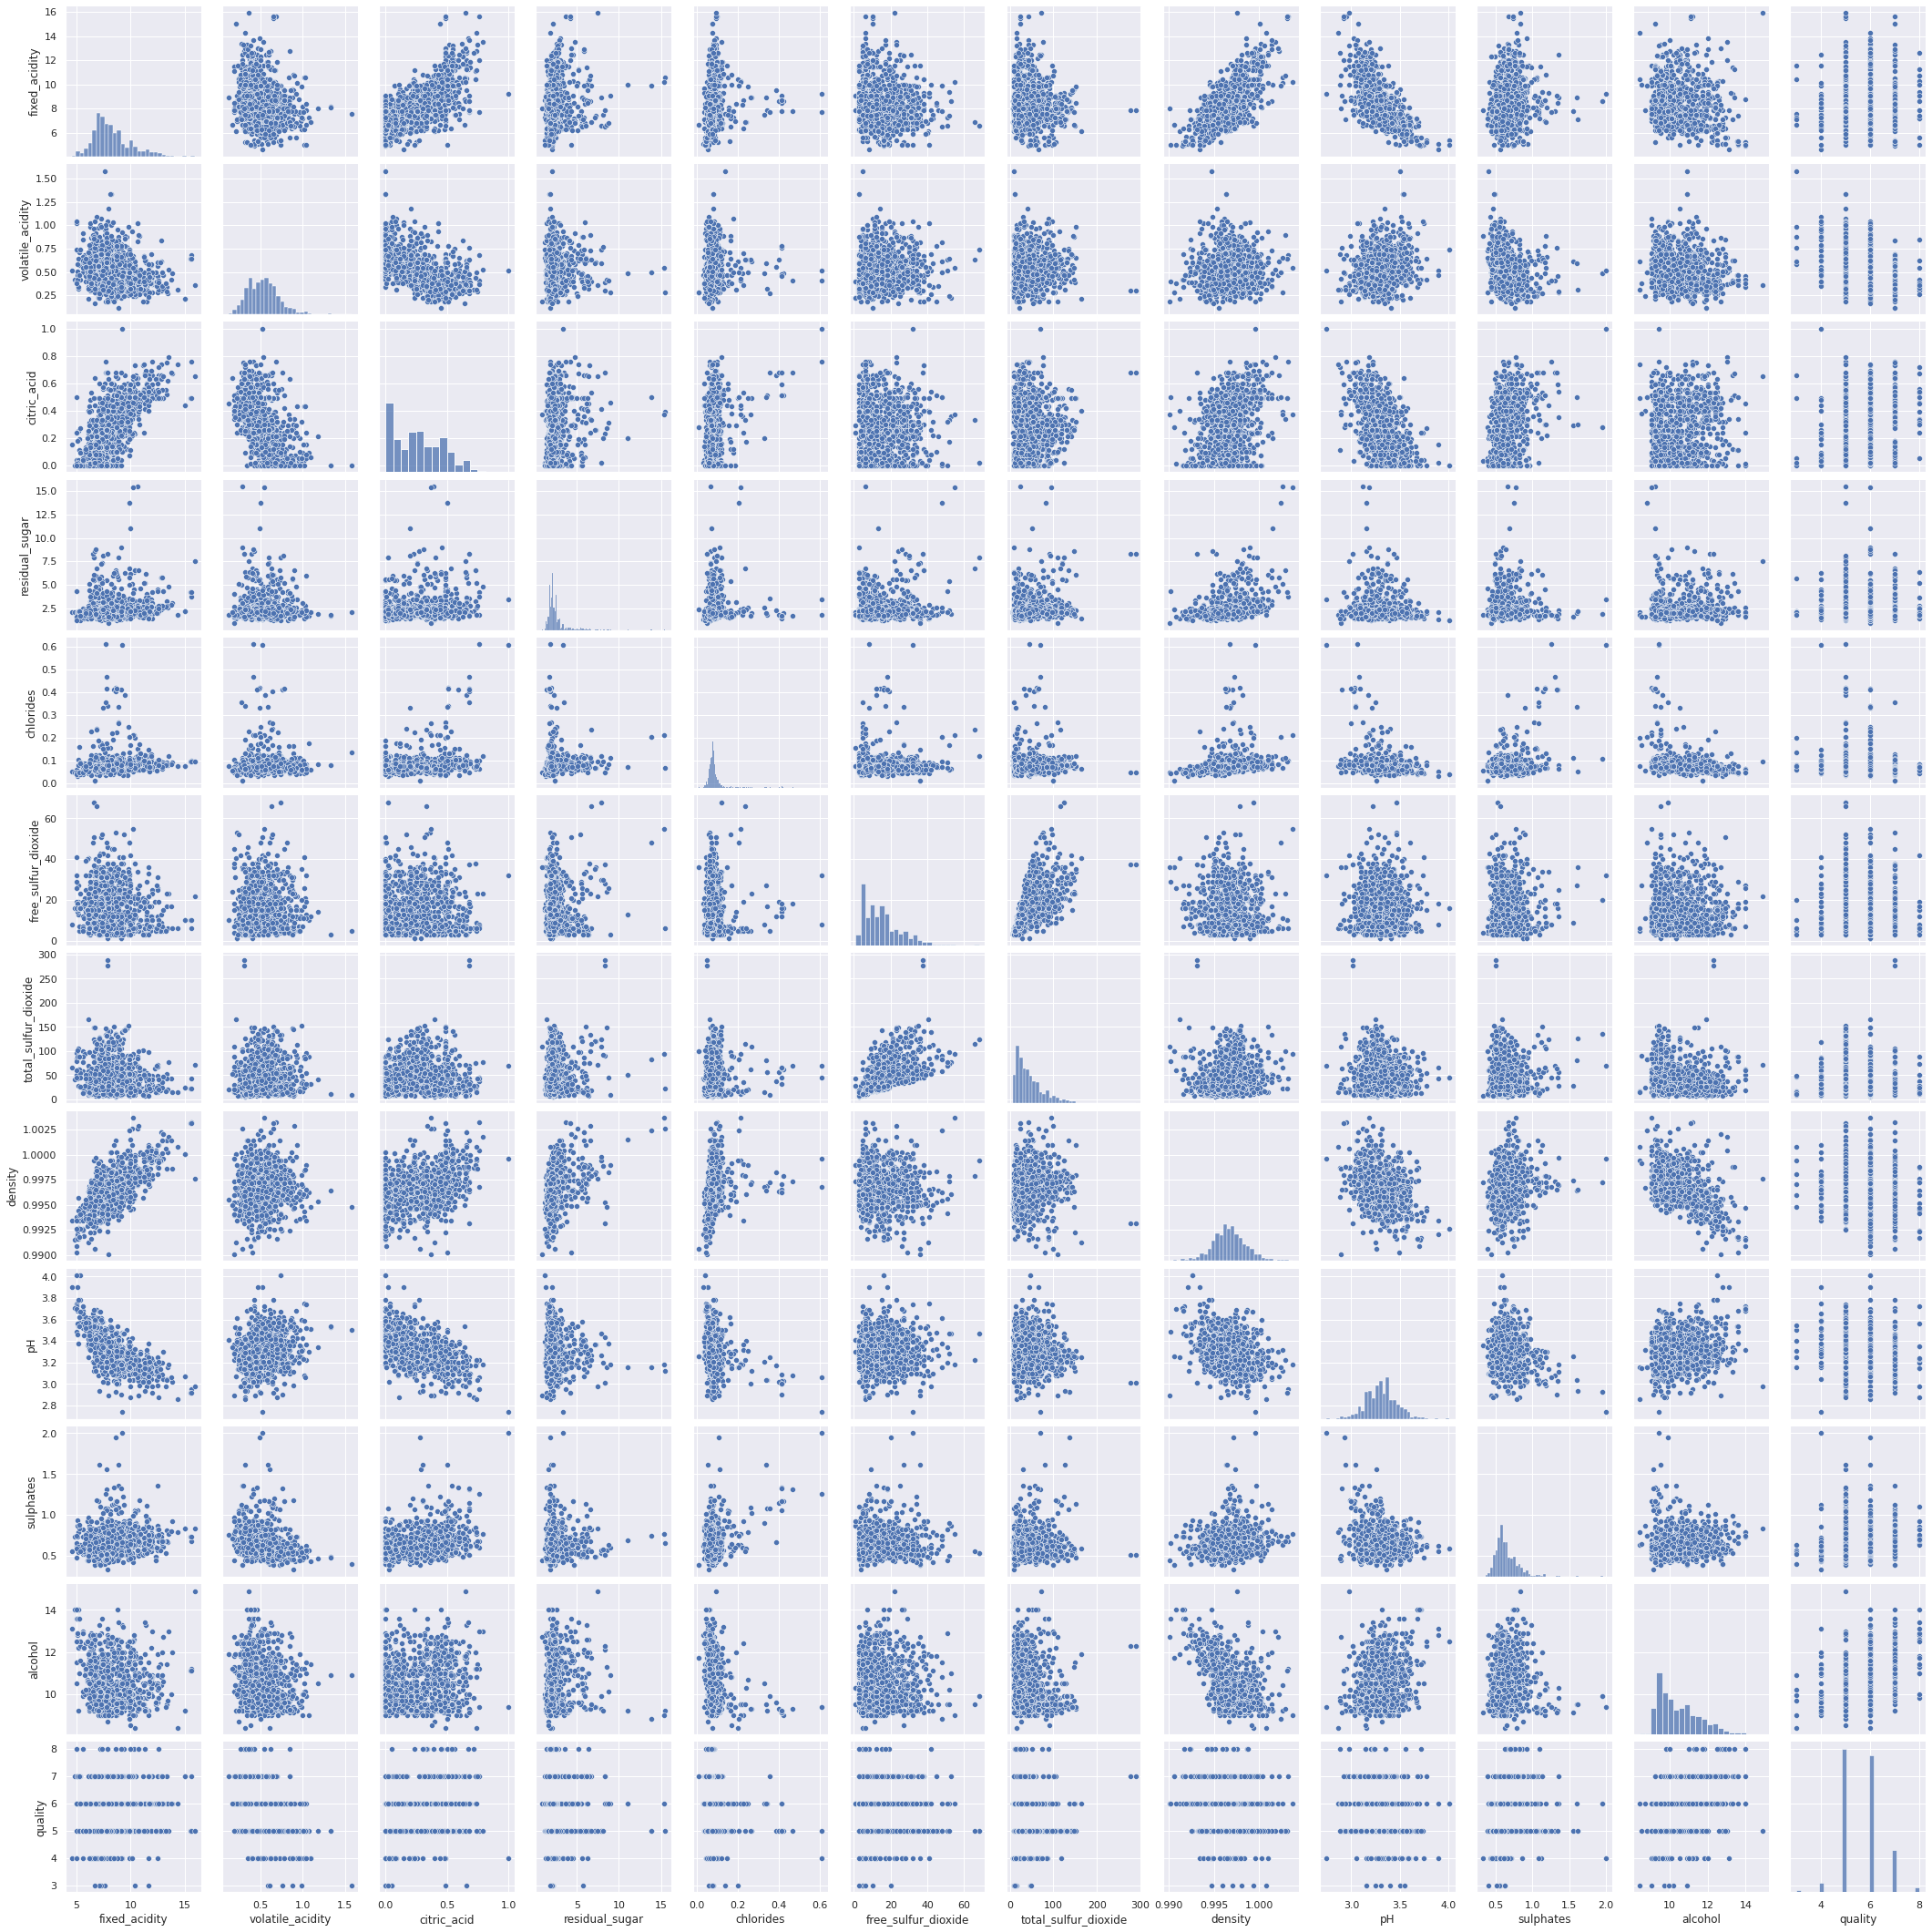

In [ ]:
# All attributes are plotted against each other to see the pattern of distribution
sns.pairplot(wine_df_pandas)

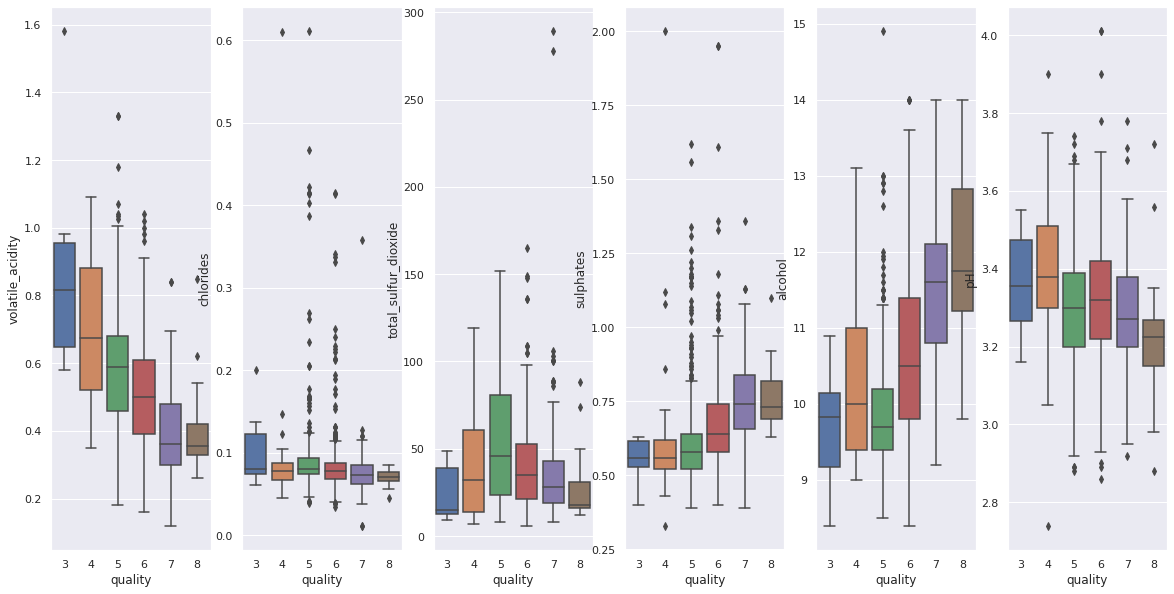

In [ ]:
names = wine_df_pandas[
    [
        "volatile_acidity",
        "chlorides",
        "total_sulfur_dioxide",
        "sulphates",
        "alcohol",
        "pH",
        "quality",
    ]
].columns.drop("quality")
ncols = len(names)
fig, axes = plt.subplots(1, ncols)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(
        y=name,
        x="quality",
        data=wine_df_pandas[
            [
                "volatile_acidity",
                "chlorides",
                "total_sulfur_dioxide",
                "sulphates",
                "alcohol",
                "pH",
                "quality",
            ]
        ],
        orient="v",
        ax=ax,
    )
plt.rcParams["figure.figsize"] = (12, 16)

### What kind of data exploration did you do?
**Preliminary findings from the EDA.**
- **Datatype Check** - All the features in the dataset are Integers/ Float.
- **Missing Data Check** - Our Dataset Didn't had any missing values in any of the features.
- **Distribution of training data** - I checked the probability distribution of each and every feature in the training dataset
- **Correlation Check** - I performed a correlation check on the dataset using heatmap and pirplot, the findings from it was that the didn't had any significant multi colinearity issues. 
- **Barplot** - Performed Barplot analysis to findout how a variable impacts the quality of wine

The above graphs are a cohesive representation of how quality of wine is changing w.r.t. all the significant variables.
- A few findings which we can interpret from the above graph as
    - Quality of wine increase as the volatile_acidity decrease
    - Quality of wine increase as the level of chlorides decrease
    - Quality of wine increase as the level of sulphates increase
    - Quality of wine increase as the level of alcohol increase

- These are the preliminary findings about how the individual parameters are affecting the quality of wine.

### Data Cleaning
- This dataset was relatively cleaner with no missing values. But handing missing values is one of the most important tasks in any Data Science project. 

### Handling Missing Data
- In any ML modeling task, one of the very important task is to check if we have any missing values in our dataset. If there are missing values in the dataset it can horribly change the results and make our model inefficient.
- But there are ways to tackle this problem, we will discuss these methods in a bit detail below

### How to handle missing data - Data Imputation techniques
1.   Delete rows with missing data
2.   Fill the missing data points by either mean/mode/median
3.   Model a regression with rest of the feature as input and the missing value as the target i.e. MICE Imputation

Our dataset doesn't have any missing values, lets deliberately create some missing values and have a comparative analysis of how effectively each method is recovering the data back.

We will remove 1%, 5% and 10% of the data from alcohol in our dataset and see how well Mean Imputation and MICE imputation will recover the data back



In [ ]:
df_imputation = wine_df_pandas.copy()
# Creating three extra coloumns of Alcohol for performing Data Imputation techniques
df_imputation["alcohol_1_percent"] = df_imputation[["alcohol"]]
df_imputation["alcohol_5_percent"] = df_imputation[["alcohol"]]
df_imputation["alcohol_10_percent"] = df_imputation[["alcohol"]]

In [ ]:
# Function to calculate percentage of missing data in dataset
def get_percent_missing(dataframe):

    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame(
        {"column_name": dataframe.columns, "percent_missing": percent_missing}
    )
    return missing_value_df


# Function to create missing values
def create_missing(dataframe, percent, col):
    dataframe.loc[dataframe.sample(frac=percent).index, col] = np.nan


# Modified function to impute data using mean imputation
def mean_impute(train_df):
    mm_impute_train_df = train_df.copy()  # Make a copy of dataframe for imputation
    mm_impute_train_df["alcohol_1_percent"] = mm_impute_train_df[
        "alcohol_1_percent"
    ].fillna(mm_impute_train_df["alcohol"].mean())
    mm_impute_train_df["alcohol_5_percent"] = mm_impute_train_df[
        "alcohol_5_percent"
    ].fillna(mm_impute_train_df["alcohol"].mean())
    mm_impute_train_df["alcohol_10_percent"] = mm_impute_train_df[
        "alcohol_10_percent"
    ].fillna(mm_impute_train_df["alcohol"].mean())
    return mm_impute_train_df


# Function to impute data using MICE method
def mice_impute(train_df):
    mice_imputed_train_df = pd.DataFrame(
        MICE().fit_transform(train_df), columns=list(train_df.columns)
    )
    return mice_imputed_train_df


# Function to calculate how well the data has been recovered after performing data imputation
def percentage_change(l1, l2):
    percent_change = abs(l2 - l1) / (l1 + 0.000000001)
    avg_change = (percent_change.sum() / percent_change.count()) * 100
    return avg_change

In [ ]:
# Checking for % missing values in dataset
print(get_percent_missing(df_imputation))

                               column_name  percent_missing
fixed_acidity                fixed_acidity              0.0
volatile_acidity          volatile_acidity              0.0
citric_acid                    citric_acid              0.0
residual_sugar              residual_sugar              0.0
chlorides                        chlorides              0.0
free_sulfur_dioxide    free_sulfur_dioxide              0.0
total_sulfur_dioxide  total_sulfur_dioxide              0.0
density                            density              0.0
pH                                      pH              0.0
sulphates                        sulphates              0.0
alcohol                            alcohol              0.0
quality                            quality              0.0
alcohol_1_percent        alcohol_1_percent              0.0
alcohol_5_percent        alcohol_5_percent              0.0
alcohol_10_percent      alcohol_10_percent              0.0


In [ ]:
# Creating missing values in respected coloumns to perform data imputation
create_missing(df_imputation, 0.01, "alcohol_1_percent")
create_missing(df_imputation, 0.05, "alcohol_5_percent")
create_missing(df_imputation, 0.1, "alcohol_10_percent")

In [ ]:
# Performing Mean Imputation
mm_imputed_df_imputation = mean_impute(df_imputation)

For MICE imputation, we have to be carefull and create three different dataframes for all three configuration, because MICE imputation uses all features in the data to predict(impute) the missing value. Having all coloumns in one dataframe can lead to the issue of co-linearity which will mislead the regression model and result in bad imputation

In [ ]:
# Dataframe for 1% missing value
df_imputation_1_percent = df_imputation.drop(
    ["alcohol", "alcohol_5_percent", "alcohol_10_percent"], axis=1
)
# Dataframe for 5% missing value
df_imputation_5_percent = df_imputation.drop(
    ["alcohol", "alcohol_1_percent", "alcohol_10_percent"], axis=1
)
# Dataframe for 10% missing value
df_imputation_10_percent = df_imputation.drop(
    ["alcohol", "alcohol_1_percent", "alcohol_5_percent"], axis=1
)

# Performing Imputation on Dataframe with 1% missing values
mice_imputed_df_imputation_1_percent = mice_impute(df_imputation_1_percent)
# Performing Imputation on Dataframe with 5% missing values
mice_imputed_df_imputation_5_percent = mice_impute(df_imputation_5_percent)
# Performing Imputation on Dataframe with 10% missing values
mice_imputed_df_imputation_10_percent = mice_impute(df_imputation_10_percent)

Lets see how our imputation methods have recovered the data

In [ ]:
# This is the average % error on residuals for 1% missing data imputed using Mean Imputation
print("Average % error on residuals for 1% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_df_imputation["alcohol"],
        mm_imputed_df_imputation["alcohol_1_percent"],
    )
)

# This is the average % error on residuals for 1% missing data imputed using MICE Imputation
print("Average % error on residuals for 1% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_imputation["alcohol"],
        mice_imputed_df_imputation_1_percent["alcohol_1_percent"],
    )
)

# This is the average % error on residuals for 5% missing data imputed using Mean Imputation
print("Average % error on residuals for 5% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_df_imputation["alcohol"],
        mm_imputed_df_imputation["alcohol_5_percent"],
    )
)

# This is the average % error on residuals for 5% missing data imputed using MICE Imputation
print("Average % error on residuals for 5% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_imputation["alcohol"],
        mice_imputed_df_imputation_5_percent["alcohol_5_percent"],
    )
)

# This is the average % error on residuals for 10% missing data imputed using Mean Imputation
print("Average % error on residuals for 10% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_df_imputation["alcohol"],
        mm_imputed_df_imputation["alcohol_10_percent"],
    )
)

# This is the average % error on residuals for 10% missing data imputed using MICE Imputation
print("Average % error on residuals for 10% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_imputation["alcohol"],
        mice_imputed_df_imputation_10_percent["alcohol_10_percent"],
    )
)

Average % error on residuals for 1% missing data imputed using Mean Imputation
0.07328591225174853
Average % error on residuals for 1% missing data imputed using MICE Imputation
0.032382858209973886
Average % error on residuals for 5% missing data imputed using Mean Imputation
0.39166260725934426
Average % error on residuals for 5% missing data imputed using MICE Imputation
0.22961527324150297
Average % error on residuals for 10% missing data imputed using Mean Imputation
0.7900651081734257
Average % error on residuals for 10% missing data imputed using MICE Imputation
0.5459178679543665


# Interpreting the Imputation Methods
- From the above 6 readings we can conclude that the MICE imputation works well when compared to the Mean imputation method as the imputed value is a function of rest of the features. 
- We can also observe that the % error of residuals increase as the missing data points increase. From this we can conclude that if we have less missing data in the dataset, more perfectly it is imputed back by the imputation method. 

# Why Imputing data is always better than deleting the row ?
- For obvious reason - Data Loss. When we delete a row we end up deleting a sample from training data which will do more harm to the model instead of doing any good.
- Selecting of imputation method is really a personal choice, although from the above analysis we can come to the conclusion that MICE does a better job in getting the databack, but after creating a model it hardly has any positive effects on the accuracy of model. But it is always a better choice to use MICE as it can give you the closest possible value.

# Feature Importance and Selection
- Lets fit a very simple linear model to understand how the features of wine are affecting its quality

In [ ]:
# Scaling the data using Min-Max scaling for the purpose of evaluating Co-efficients, as non scaled data may mislead while we evaluate the co-efficients
df = wine_df_pandas.drop(["quality"], axis=1)
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm = pd.concat((df_norm, wine_df_pandas.quality), 1)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
import statsmodels.formula.api as smf  # OLS model Library

results = smf.ols(
    "quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide +density + pH + sulphates + alcohol",
    data=df_norm,
).fit()
print(results.summary())  # OLS Linear Model Summary

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     61.49
Date:                Sun, 01 May 2022   Prob (F-statistic):          4.26e-107
Time:                        00:08:50   Log-Likelihood:                -1106.7
No. Observations:                1143   AIC:                             2237.
Df Residuals:                    1131   BIC:                             2298.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.7445 

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# Feature Selection
Feature Selection is the process of selecting the features which are relevant to a machine learning model. It means that you select only those attributes that have a significant effect on the model’s output.

Consider the case when you go to the departmental store to buy grocery items. A product has a lot of information on it, i.e., product, category, expiry date, retail cost, ingredients, and manufacturing details. All this information is the features of the product. Normally, you check the brand, retail cost, expiry date, weather the item is vegetarian or not before buying a product. However, manufacturing section is not your concern. Therefore, brand, retail cost, expiry date, vegetraian/non-vegetarian are relevant features, and the manufacturing details are irrelevant. This is how feature selection is done. 

# Null-Hypothesis
### For Example:- Testing the efficacy of a new Vaccine
Any new vaccine manufacturer has to conduct a double blind clinical controlled trials to check the efficacy of any vaccine in the general population. Now to test the vaccine, manufacturer will likely recruite around 60k people from all over the population where 30k would be vaccinated by a vaccine and rest 30k would be given a placebo. After few months the it was found that 500 people from vaccinated group got the diesease whereas 10000 people from placebo group got the dieases. This translate to a vaccine efficacy of 95%. i.e. those who received the vaccine were at a 95% lower risk of developing disease than the group who received the placebo. Now, this finding on a subset of 60k individuals is generalized over the whole population of man kind. These assumption is known as Null-Hypothesis.  

Statistically, this can be achieved by P-Value.

**P-Value** - It stands for ‘probability value’; it tells how likely it is that a result occurred by chance alone. Basically, the p-value is used in hypothesis testing to help you support or reject the null hypothesis. The smaller the p-value, the stronger the evidence to reject the null hypothesis.

Features in our dataset with P value < 0.05
*   volatile_acidity
*   chlorides
*   total_sulfur_dioxide
*   sulphates
*   alcohol

Lets consider only these features and calculate the model fit again, and then lets have a comparative analysis of both models.





In [ ]:
df_norm_feature_selected = df_norm[
    [
        "volatile_acidity",
        "chlorides",
        "total_sulfur_dioxide",
        "sulphates",
        "alcohol",
        "pH",
        "quality",
    ]
]

In [ ]:
results2 = smf.ols(
    "quality ~ volatile_acidity + chlorides + total_sulfur_dioxide + sulphates + alcohol + pH",
    data=df_norm_feature_selected,
).fit()
print(results2.summary())  # OLS Linear Model Summary

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     112.6
Date:                Sun, 01 May 2022   Prob (F-statistic):          1.81e-111
Time:                        00:08:50   Log-Likelihood:                -1107.9
No. Observations:                1143   AIC:                             2230.
Df Residuals:                    1136   BIC:                             2265.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.7206 

In [ ]:
predicted_quality_1 = results.predict(
    df_norm[
        [
            "fixed_acidity",
            "volatile_acidity",
            "citric_acid",
            "residual_sugar",
            "chlorides",
            "free_sulfur_dioxide",
            "total_sulfur_dioxide",
            "density",
            "pH",
            "sulphates",
            "alcohol",
        ]
    ]
)
df_norm["predicted_quality_1"] = predicted_quality_1.round()

In [ ]:
predicted_quality_2 = results2.predict(
    df_norm_feature_selected[
        [
            "volatile_acidity",
            "chlorides",
            "total_sulfur_dioxide",
            "sulphates",
            "alcohol",
            "pH",
        ]
    ]
)
df_norm_feature_selected["predicted_quality_2"] = predicted_quality_2.round()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(
    "Accuracy of predicting the correct quality of wine using all features = ",
    100 - percentage_change(df_norm["quality"], df_norm["predicted_quality_1"]),
)
print(
    "Accuracy of predicting the correct quality of wine using only significant features is = ",
    100
    - percentage_change(
        df_norm_feature_selected["quality"],
        df_norm_feature_selected["predicted_quality_2"],
    ),
)

Accuracy of predicting the correct quality of wine using all features =  92.43292505247338
Accuracy of predicting the correct quality of wine using only significant features is =  92.43000875034555


- From the above two summaries we can interpret that after selecting only the significant features(features with P value less than 0.05) it had little to no effect on the outcome compare to the model which uses all the features.

- From the above two interpretations, our observation is that in both the cases our model predicts the quality of wine pretty good and they are pretty close to each other. Model who uses all features slighly overcomes the model who is using only the statistically important features with and accuracy of **92.432% compared to the 92.43 %** of the later

- From the above studies let's stick to the data with all featues and try using different models

In [ ]:
df_norm = df_norm.drop(["predicted_quality_1"], axis=1)

In [ ]:
X = df_norm.drop(["quality"], axis=1)  # Training Feature
Y = df_norm["quality"]  # Target

### How did you split the data into train, and test?

- The data was splitted into Training ad Testing Data into 90% and 10% respectively.

In [ ]:
(
    x_train,
    x_test,
    y_train,
    y_test,
) = train_test_split(  # Splitting Data into Training and Test
    X, Y, test_size=0.1, random_state=42
)
x_train_100 = shap.utils.sample(
    x_train, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process
x_test_100 = shap.utils.sample(
    x_test, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process

### Fitting a Linear Model

In [ ]:
import sklearn

linear_model = sklearn.linear_model.LinearRegression()  # Initializing a Linear Model
linear_model.fit(x_train, y_train)  # Training a linear model

LinearRegression()

In [ ]:
y_linear_predictions = linear_model.predict(x_test).round()

### Fitting a Tree Based Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

tree_model = RandomForestRegressor(
    max_depth=X.shape[1], random_state=0, n_estimators=10
)
tree_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=11, n_estimators=10, random_state=0)

In [ ]:
y_tree_based_predictions = tree_model.predict(x_test).round()

### Fitting a Support Vector Machine (SVM)

In [ ]:
from sklearn import svm

regr = svm.SVR()
svm_model = regr.fit(x_train, y_train)

In [ ]:
svm_predictions = svm_model.predict(x_test).round()

### Fitting a MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train)

In [ ]:
mlp_predictions = regr.predict(x_test).round()

### Using AutoML to find out the best Model

In [ ]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [ ]:
# Setting up memory
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


In [ ]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:31619 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_47mjrgp
  JVM stdout: /tmp/tmp_47mjrgp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_47mjrgp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:31619
Connecting to H2O server at http://127.0.0.1:31619 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    17 days
H2O_cluster_name:           H2O_from_python_unknownUser_ixwobr
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:31619
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.13 final
--------------------------  ----------------------------------

In [ ]:
wine_hf = h2o.H2OFrame(wine_df_pandas)  # Converting Pandas dataframe in H2O dataframe

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = wine_hf.split_frame([pct_rows])

In [ ]:
# Setting up AutoML
def autoML(df_train, df_test):

    X = df_train.columns
    y = "quality"

    X.remove(y)  # Removing the result frm our predictors data

    aml = H2OAutoML(max_runtime_secs=222, seed=1)  # Setting of AutoML
    aml.train(
        x=X, y=y, training_frame=df_train
    )  # Trainig the dataset on different models

    return df_train, df_test, aml


# Function to get best model from the AutoML leaderboard
def getBestModel(aml):
    model_index = 0
    glm_index = 0
    glm_model = ""
    aml_leaderboard_df = aml.leaderboard.as_data_frame()
    models_dict = {}

    for m in aml_leaderboard_df["model_id"]:
        models_dict[m] = model_index
        if "StackedEnsemble" not in m and "GBM" not in m:
            break
        model_index = model_index + 1

    for m in aml_leaderboard_df["model_id"]:
        if "GLM" in m:
            models_dict[m] = glm_index
            break
        glm_index = glm_index + 1

    print(model_index)
    best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])
    return best_model

In [ ]:
autoML = autoML(df_train, df_test)  # Training AutoML

AutoML progress: |█████████████████████████████████████████████████████████████
00:12:40.603: GBM_lr_annealing_selection_AutoML_1_20220501_00903 [GBM lr_annealing] failed: water.exceptions.H2OIllegalArgumentException: Can only convert jobs producing a single Model or ModelContainer.

██| (done) 100%


In [ ]:
autoML[2].leaderboard  # Leaderbord of AutoML output

model_id rmse mse mae rmsle mean_residual_deviance 
 
 
 StackedEnsemble_AllModels_4_AutoML_1_20220501_00903 0.593749 0.352538 0.439083 0.0917824 0.352538 
 StackedEnsemble_AllModels_3_AutoML_1_20220501_00903 0.594329 0.353226 0.439319 0.0918613 0.353226 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220501_00903 0.594421 0.353337 0.429041 0.0919488 0.353337 
 StackedEnsemble_AllModels_2_AutoML_1_20220501_00903 0.594656 0.353615 0.429101 0.0919983 0.353615 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220501_00903 0.596229 0.355488 0.42955 0.0921929 0.355488 
 XRT_1_AutoML_1_20220501_00903 0.59744 0.356934 0.437541 0.092558 0.356934 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220501_00903 0.598534 0.358243 0.435624 0.0923776 0.358243 
 StackedEnsemble_AllModels_1_AutoML_1_20220501_00903 0.599123 0.358948 0.43565 0.092526 0.358948 
 DRF_1_AutoML_1_20220501_00903 0.60362 0.364358 0.443615 0.093339 0.364358 
 GBM_4_AutoML_1_20220501_00903 0.604045 0.364871 0.453417 0.0932077 0.364871

In [ ]:
autoML_model = getBestModel(autoML[2])  # Getting Best Model

5


In [ ]:
autoML_best_predictions = autoML_model.predict(df_test).round()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
autoMLpredictions = h2o.as_list(autoML_best_predictions, use_pandas=False)
y_test_h2O = h2o.as_list(df_test["quality"], use_pandas=False)

In [ ]:
def flatten(t):
    listt = [(item) for sublist in t for item in sublist][1:]
    listt = [float(x) for x in listt]
    x = pd.Series(listt)
    return x

In [ ]:
autoMLpredictions = flatten(autoMLpredictions)
y_test_h2O = flatten(y_test_h2O)

# Hyperparameter Tuning of AutoML's Best Model

In [ ]:
train, validate, test = np.split(
    wine_df_pandas.sample(frac=1, random_state=42),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)
train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

drf_hyper_params = {
    "ntrees": [10, 25, 50, 75, 100],
    "max_depth": [5, 7, 10, 14],
    "sample_rate": [0.25, 0.5, 0.75, 1.0],
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 100, "seed": 1}

gbm_grid2 = H2OGridSearch(
    model=H2ORandomForestEstimator,
    grid_id="gbm_grid2",
    hyper_params=drf_hyper_params,
    search_criteria=search_criteria,
)

gbm_grid2.train(
    x=list(X.columns),
    y="quality",
    training_frame=train,
    validation_frame=validate,
    seed=1,
)


def find_best_model_from_grid(h2o_grid, test_parameter):
    model_list = []
    for grid_item in h2o_grid:
        if test_parameter is "r2":
            if not (grid_item.r2() == "NaN"):
                model_list.append(grid_item.r2())
            else:
                model_list.append(0.0)
        elif test_parameter is "auc":
            if not (grid_item.auc() == "NaN"):
                model_list.append(grid_item.auc())
            else:
                model_list.append(0.0)
    max_index = model_list.index(max(model_list))
    best_model = h2o_grid[max_index]
    print("Model ID with best R2: " + best_model.model_id)
    if test_parameter is "r2":
        print("Best R2: " + str(best_model.r2()))
    elif test_parameter is "auc":
        print("Best AUC: " + str(best_model.auc()))
    return best_model


best_drf_model = find_best_model_from_grid(gbm_grid2, "r2")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Model ID with best R2: gbm_grid2_model_78
Best R2: 0.4025083234563227


### What evaluation metric are you using?

- The evaluation metrics which I am using are 
    - Mean Squared Error
    - Root Mean Squared Error
    - Mean Absolute Error
    - Mean Residual Deviance
    - Accuracy
- These evaluation metrics are used to evaluate the best model, as it is a regression problem. Here, Mean Residual Deviance and Accuracy are the most important metrics used to evaluate the mode. 

- The residual deviance tells us how well the response variable can be predicted by a model with p predictor variables. The lower the value, the better the model is able to predict the value of the response variable.

- Accuracy tells us how correct and precise our model is. 

### How do training, validation, and test metrics compare?

- The best model (AutoML's Hyperparameter tuned model) has done pretty well on both the Training Dataset as well as Validation Dataset. 

- As the Mean Residual Deviance of this model on training and validation dataset is ~0.3929 and ~0.3534 respectively. Also, the other metrics on both of the dataset validates that the model is not overfitting the Training Data. Please refer below to see the Evaluation Metrics on both training and validation dataset.


In [ ]:
best_drf_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  gbm_grid2_model_78


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               75.0                      75.0             128914.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       12.0       14.0   13.866667       112.0       154.0    132.06667



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.39295336227752575
RMSE: 0.6268599223730337
MAE: 0.4674894967835796
RMSLE: 0.09741748020843956
Mean Residual Deviance: 0.39295336227752575

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.3534326529821666
RMSE: 0.5945020210076385
MAE: 0.43885675169321514
RMSLE: 0.09197864095359155
Mean Residual Deviance: 0.3534326529821666

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-05-01 00:13:25  35.451 sec              0.0            NaN   
1     2022-05-01 00:13:25  35.458 sec              1.0       0.919557   
2     2022-05-01 00:13:25  35.463 sec              2.0       0.858670   
3     2022-05-01 00:13:25  35.468 sec              3.0       0.800154   
4     2022-05-01 00:13:25  35.478 sec              4.0       0.801834   
5     2022-05-01 00:13:25  35.484 sec              5.0       0.763510   
6     2022-05-01 00:13:25  35.490 sec              6.0       0.742417   
7     2022-05-01 00:13:25  35.496 sec              7.0       0.729471   
8     2022-05-01 00:13:25  35.505 sec              8.0       0.717240   
9     2022-05-01 00:13:25  35.510 sec              9.0       0.706161   
10    2022-05-01 00:13:25  35.516 sec             10.0       0.696997   
11    2022-05-01 00:13:25  35.522 sec             11.0       0.680382   
12    2022-05-01 00:13:25  35.528 sec             12.0       0.676660   
13    2022-05-01 00:13:25  35.534 sec             13.0       0.669299   
14    2022-05-01 00:13:25  35.542 sec             14.0       0.663529   
15    2022-05-01 00:13:25  35.549 sec             15.0       0.660579   
16    2022-05-01 00:13:25  35.557 sec             16.0       0.656881   
17    2022-05-01 00:13:25  35.565 sec             17.0       0.658132   
18    2022-05-01 00:13:25  35.572 sec             18.0       0.655810   
19    2022-05-01 00:13:25  35.585 sec             19.0       0.657045   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1       0.623364           0.845586         0.887128        0.588064   
2       0.573819           0.737314         0.737488        0.519469   
3       0.547609           0.640246         0.729346        0.545002   
4       0.564129           0.642937         0.691299        0.514101   
5       0.538963           0.582947         0.672729        0.494916   
6       0.528429           0.551183         0.653805        0.479024   
7       0.520595           0.532128         0.638440        0.476926   
8       0.510445           0.514433         0.638341        0.477237   
9       0.498546           0.498663         0.635565        0.472635   
10      0.491145           0.485804         0.628172        0.461984   
11      0.483392           0.462919         0.624209        0.461500   
12      0.484523           0.457869         0.624939        0.456642   
13      0.477772           0.447961         0.620907        0.454994   
14      0.474251           0.440270         0.618831        0.448278   
15      0.477519           0.436364         0.615410        0.445467   
16      0.475730           0.431492         0.613243        0.446048   
17      0.475579           0.433138         0.610162        0.444193   
18      0.476692           0.430087         0.613752        0.446929   
19      0.480948           0.431708         0.611307        0.443880   

    validation_deviance  
0                   NaN  
1              0.786997  
2              0.543888  
3              0.531946  
4              0.477895  
5              0.452564  
6              0.427461  
7              0.407606  
8              0.407479  
9              0.403942  
10             0.394601  
11             0.389637  
12             0.390549  
13             0.385525  
14             0.382952  
15             0.378729  
16             0.376067  
17             0.372298  
18             0.376692  
19             0.373696


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0                alcohol          3827.912354           1.000000    0.205418
1              sulphates          3242.052490           0.846951    0.173979
2       volatile_acidity          2249.830322           0.587743    0.120733
3                density          1707.978882           0.446191    0.091655
4            citric_acid          1345.073853           0.351386    0.072181
5   total_sulfur_dioxide          1315.517334           0.343664    0.070595
6          fixed_acidity          1104.050415           0.288421    0.059247
7              chlorides          1047.584839           0.273670    0.056217
8                     pH          1043.337891           0.272561    0.055989
9    free_sulfur_dioxide           899.323792           0.234938    0.048261
10        residual_sugar           852.106323           0.222603    0.045727

In [ ]:
# Evaluating the model on Test Data
autoML_best_predictions_2 = best_drf_model.predict(df_test).round()
autoMLpredictions_2 = h2o.as_list(autoML_best_predictions_2, use_pandas=False)
y_test_h2O_2 = h2o.as_list(df_test["quality"], use_pandas=False)
autoMLpredictions_2 = flatten(autoMLpredictions_2)
y_test_h2O_2 = flatten(y_test_h2O_2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


### Which models did you explore and did you try to tune the hyperparameters of the best model you got?
- I trained multiple models for this purpose including the simplest Linear Regression to using AutoML to get the best model it could fit. The models I trained for this purpose were 
    - Linear Regressor
    - Random Forest Regressor
    - MLP Regressor
    - Support Vector Machine(SVM) Regressor
    - AutoML
- The models which gave me the best performance in predicting the quality of wine were the SVM and the model from AutoML where the model from AutoML slightly outpaced the SVM. The model from AutoML to give the best result was a RandomForestRegressor.

- As the AutoML's model was promising, I tuned its hyperparameters to oprimize the model. Tunining the hyperparameters helped the model to incease its accuracy from **93.25 % to 96.08 %** which is a great increase in the performance.

In [ ]:
print(
    "Accuracy of predicting the correct quality of wine using MLP Regressor = ",
    100 - percentage_change(y_test, mlp_predictions),
)
print(
    "Accuracy of predicting the correct quality of wine using Linear Model = ",
    100 - percentage_change(y_test, y_linear_predictions),
)
print(
    "Accuracy of predicting the correct quality of wine using Tree Based Model = ",
    100 - percentage_change(y_test, y_tree_based_predictions),
)
print(
    "Accuracy of predicting the correct quality of wine using SVM = ",
    100 - percentage_change(y_test, svm_predictions),
)
print(
    "Accuracy of predicting the correct quality of wine using best AutoML model = ",
    100 - percentage_change(y_test_h2O, autoMLpredictions),
)
print(
    "Accuracy of predicting the correct quality of wine using best AutoML model with Tuned Hyper-Parameters = ",
    100 - percentage_change(y_test_h2O_2, autoMLpredictions_2),
)

Accuracy of predicting the correct quality of wine using MLP Regressor =  92.48964803448521
Accuracy of predicting the correct quality of wine using Linear Model =  92.70082815868818
Accuracy of predicting the correct quality of wine using Tree Based Model =  93.11490683354137
Accuracy of predicting the correct quality of wine using SVM =  93.374741202009
Accuracy of predicting the correct quality of wine using best AutoML model =  93.56481481602
Accuracy of predicting the correct quality of wine using best AutoML model with Tuned Hyper-Parameters =  96.20315255805913


# Model Selection
From the above summary of the models trained on the dataset, the two best models are SVM and AutoML's best model with tuned hyperparameters. 
*   SVM Regressor with an Accuracy of ~ 93.37%
*   AutoML's Hyperparameter Tuned Version ~ 96.20%

Let's try to understand how both the models have been trained.

**Interpreting SVM Regressor using SHAP values**
- Here the x-axis is the feature and the y-axis is the output as we vary the feature. The grey histogram is the distribution of variables in the dataset and the cross made by E[Feature], E[f(x)] is the expected values.

- Let us take a feature of fixed_acidity
  - The cross is made at approx  E[f(x)] 5.74

So as the fixed_acidity increases the expected value also increases

Talking about the red line on the plot - When we give a sample as an input (sample_ind = 18) as an input to check the output. By plotting this we can see the difference between the model output from the expected value. 



In [ ]:
svm_explainer = shap.Explainer(svm_model.predict, x_train_100)
svm_shap_values = svm_explainer(x_train_100)

Permutation explainer: 101it [04:37,  2.83s/it]


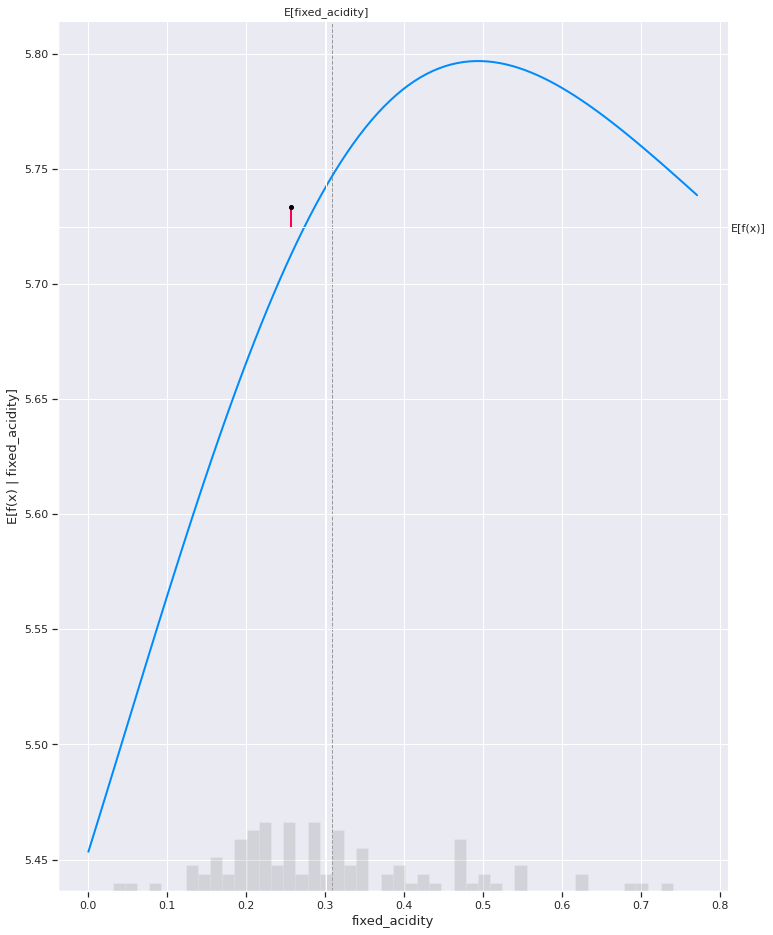

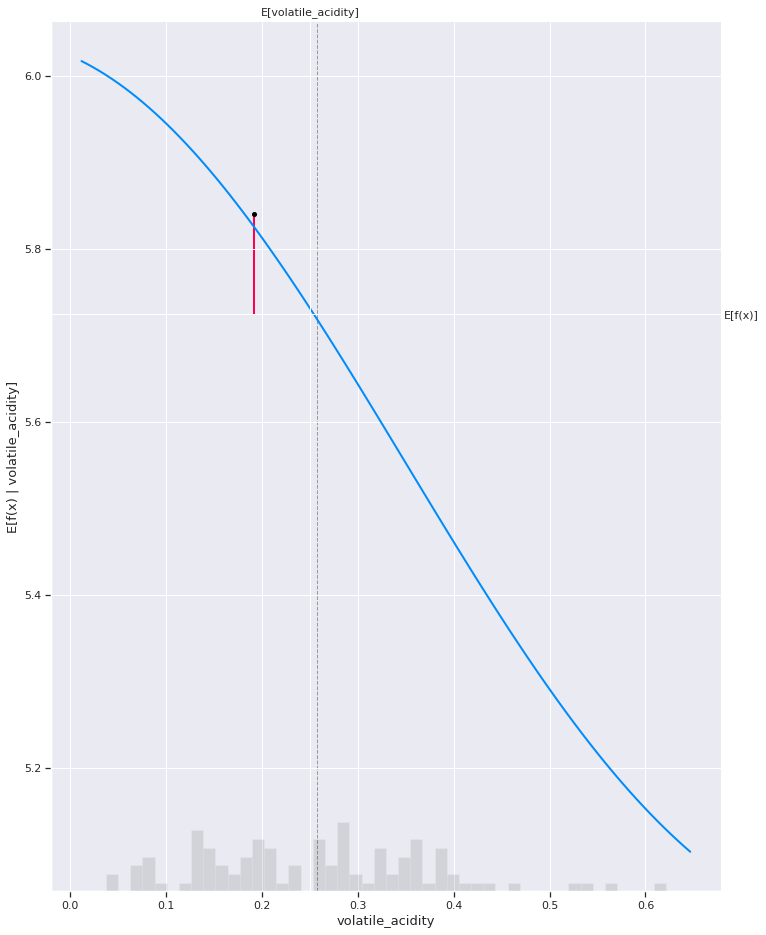

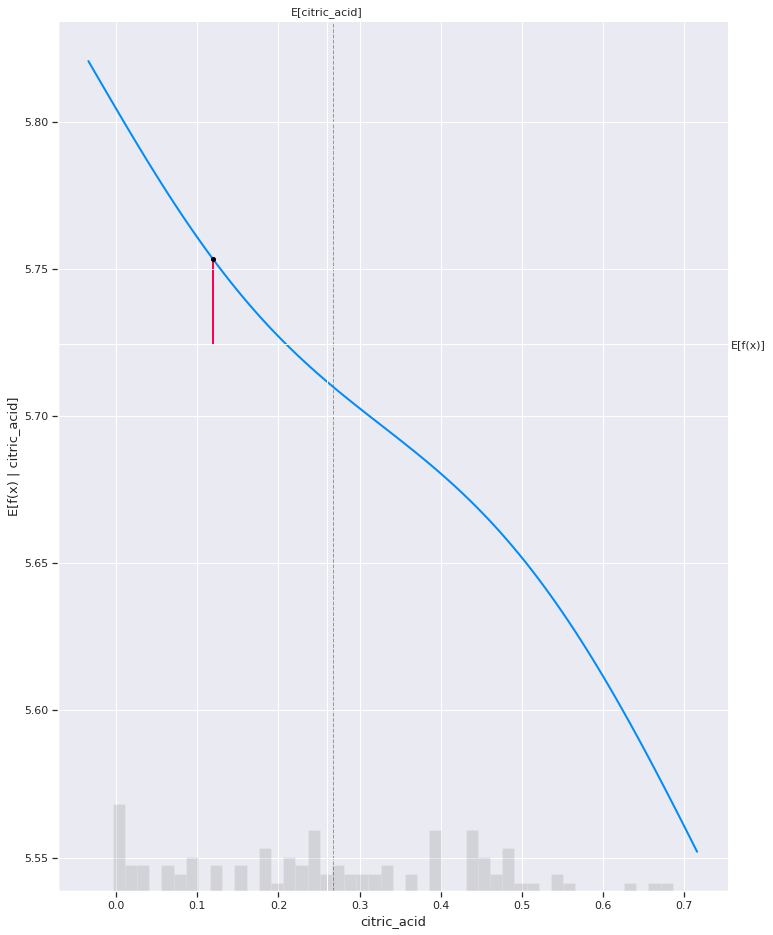

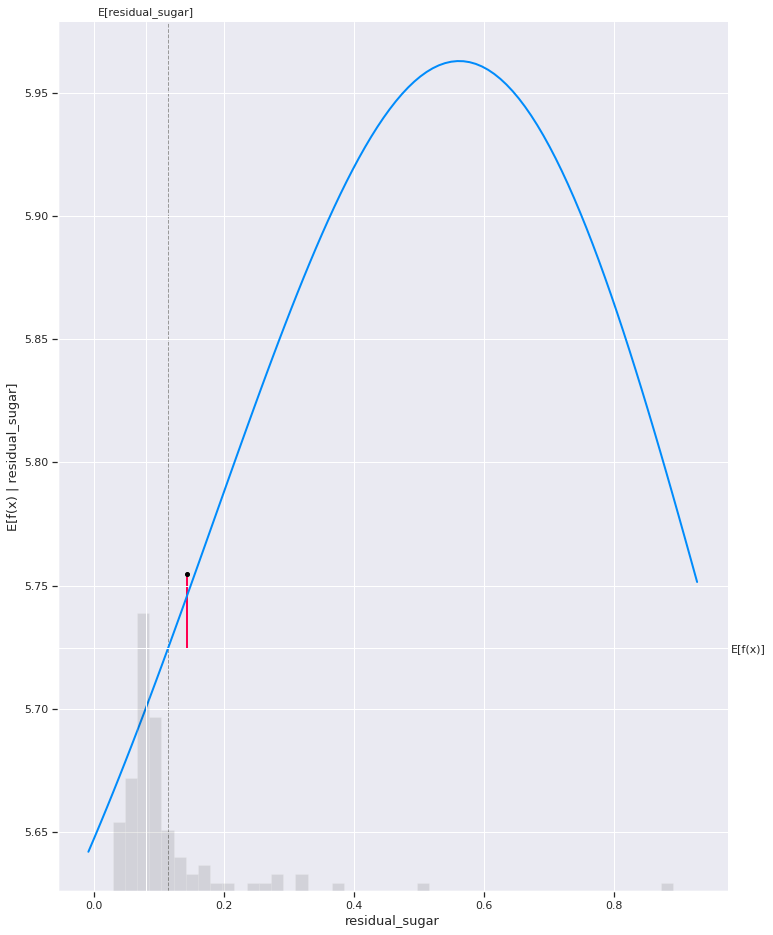

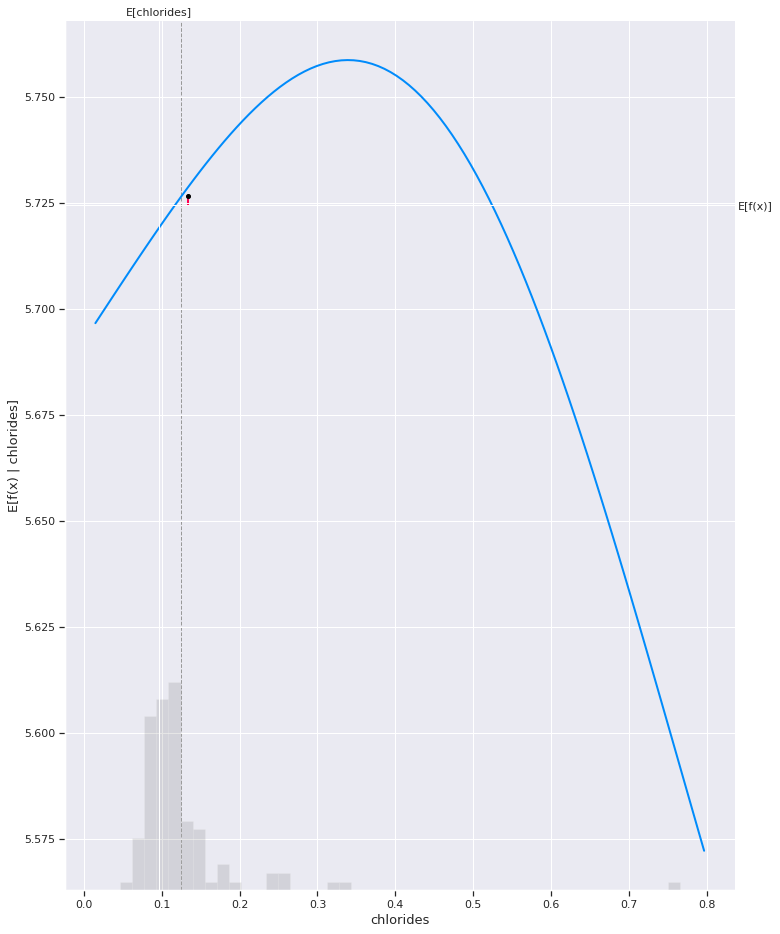

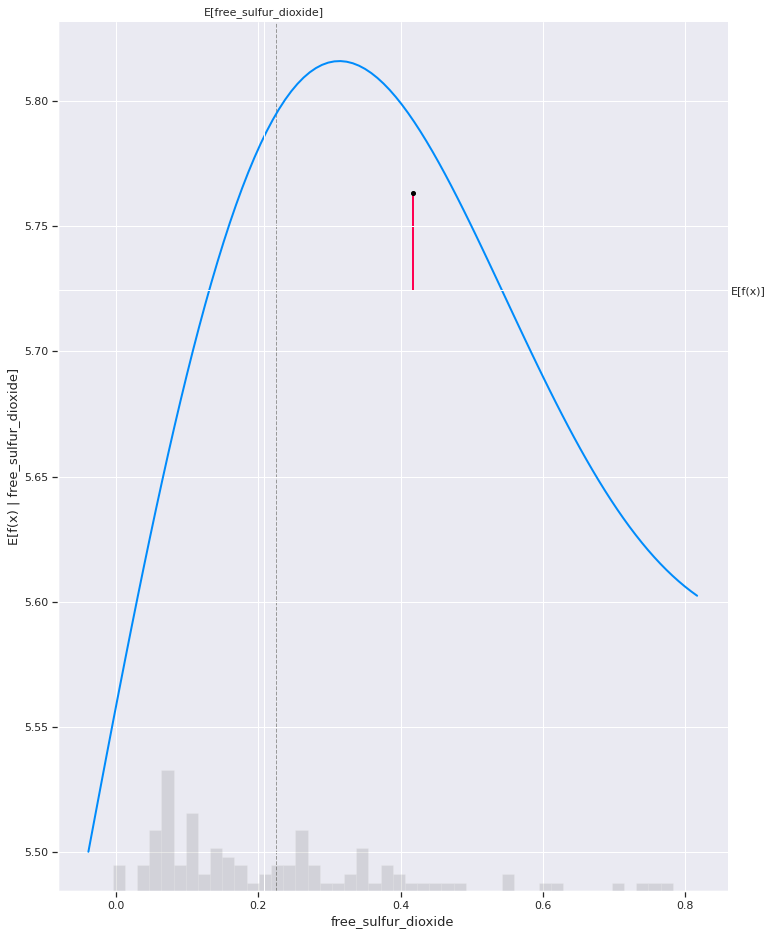

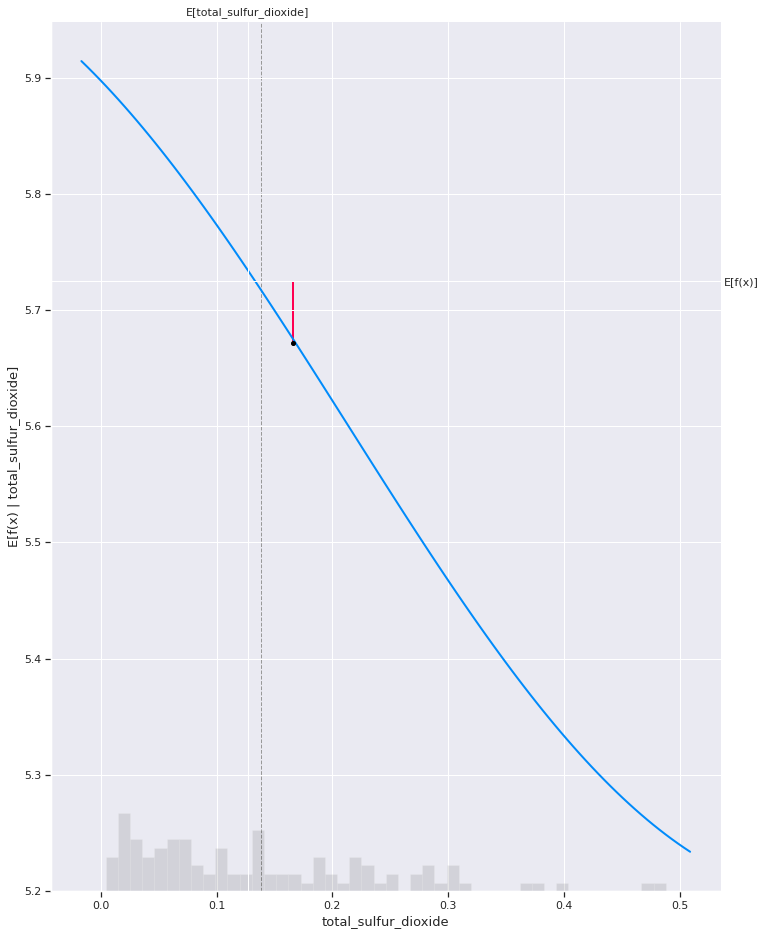

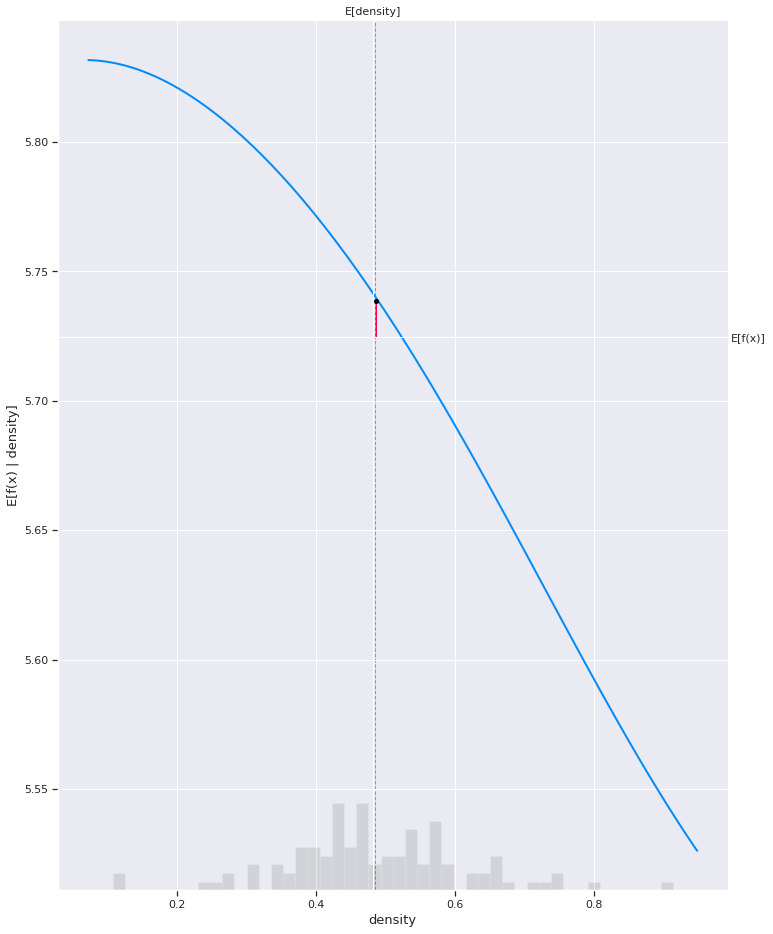

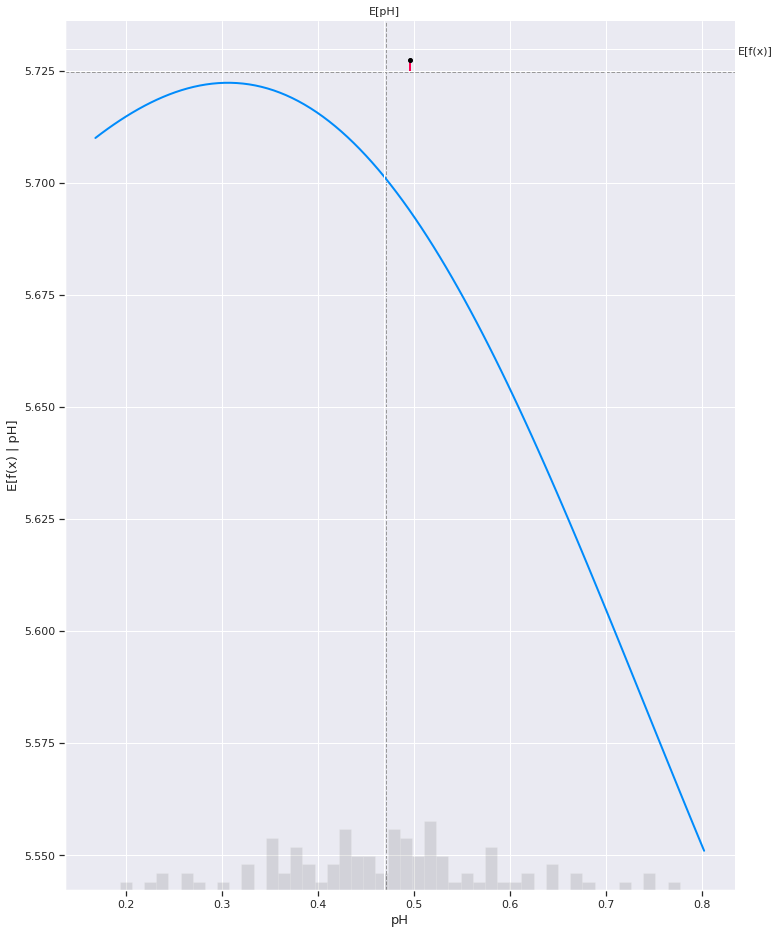

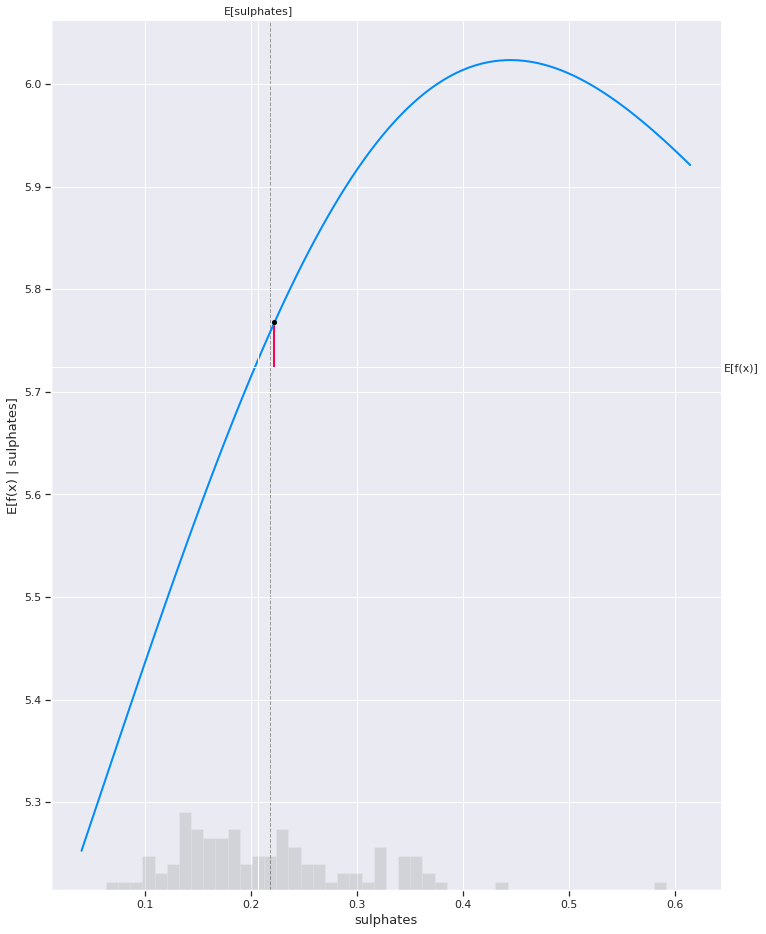

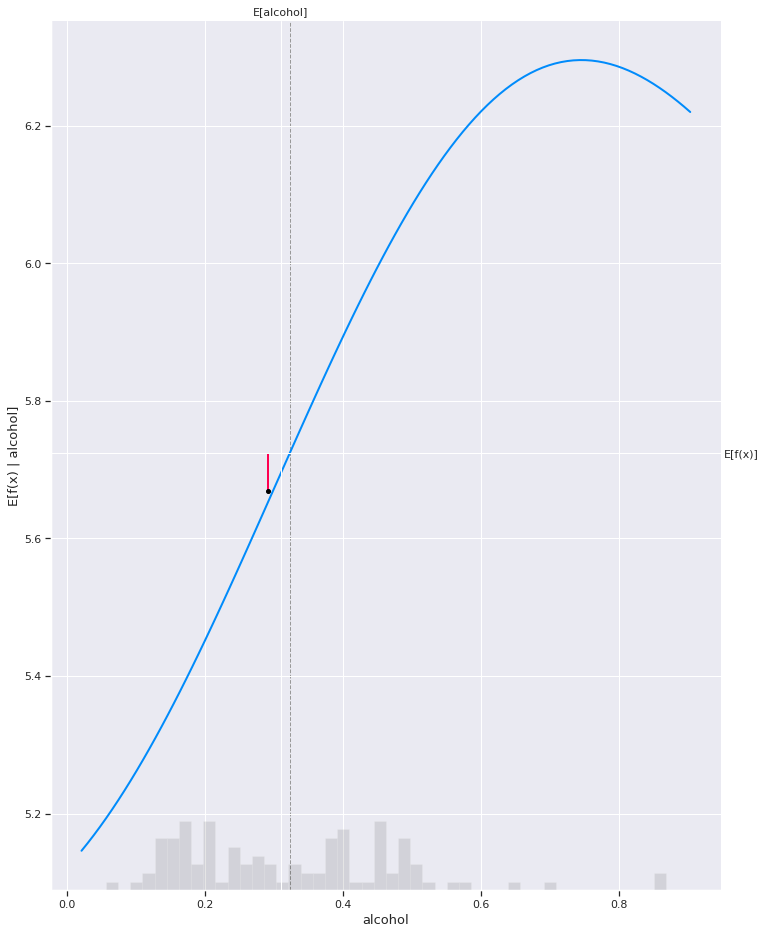

In [ ]:
for i in x_train_100.columns:
    # make a standard partial dependence plot
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        svm_model.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=svm_shap_values[sample_ind : sample_ind + 1, :],
    )

**Interpreting SHAP Feature Importance Plot for Linear and Tree-based model**
- The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want global importance, we average the absolute Shapley values per feature across the data. Next, we sort the features by decreasing importance and plot them.

- The following plot is 
  - SHAP feature importance plot for SVM model

- Using the below plot we can come on the conclusion that the alcohol is the most important feature, followed by volatile_acidity and sulphate. 

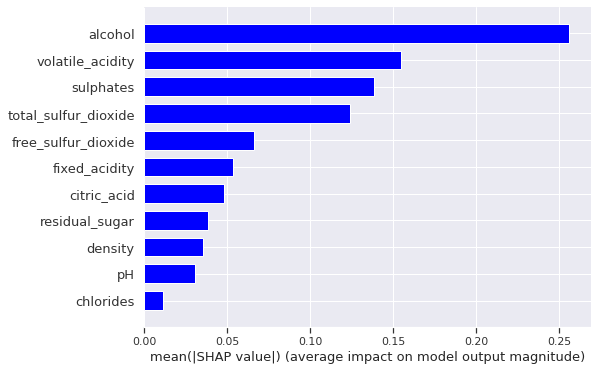

In [ ]:
# SHAP variable importance for a Linear Model
shap.summary_plot(svm_shap_values, x_train, plot_type="bar", color="blue")

In [ ]:
# Waterfall plot for linear model
def get_SHAP(index=18):
    shap.plots.waterfall(svm_shap_values[index], max_display=14)

#Interpreting Waterfall SHAP visualization

- Let's consider the same sample (sample_ind = 18).
It says that **f(x) = 5.9 is what we got as a model output** and the **expected output for this sample was 5.725**. We came pretty close to determining it as the **difference is only 0.175**. The waterfall model explains how we got the expected output, and which features contributed to what. The below graph shows that volatile_acidity has the biggest and most positive impact in **increasing the quality of wine by 0.12** for this specific sample. Followed by alcohol had a negative impact and it bought the **quality of wine down again by 0.06** for this sample, and so on. Using this model we can visually interpret why exactly this specific sample is giving an output of 5.725





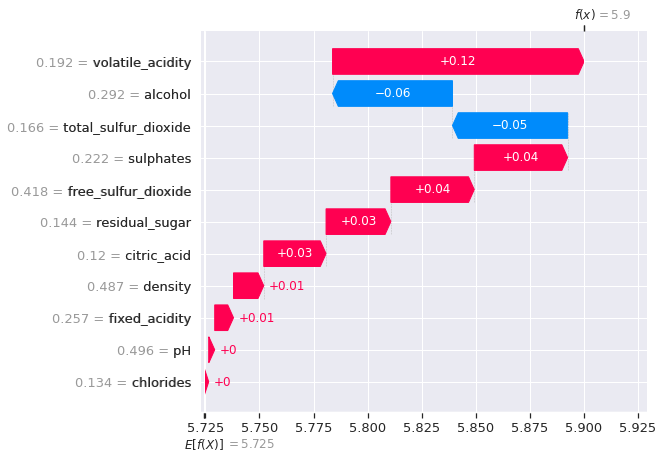

In [ ]:
get_SHAP()

#Interpret the summary plot SVM Model
- Here the features are listed in descending order of their importance. This is one of the easiest ways to analyze an ML model and how the features are affecting the target and to what extent. 

  1. Each dot(both red and blue) represents a feature of a wine
  2. Red color represents high values whereas blue color represents low value
  3. If a dot(a feature of wine) is on the right side of the y-axis then it had a positive impact and if it is on the left side of the axis it had a negative impact
  4. The position of a dot(a feature of wine) on the x-axis represents the intensity of impact it had, the more it is away from the axis greater the intensity.

- Let us try to understand how the features are affecting the model.

  *   Higher value of alcohol tends to have a positive impact on the quality of wine
  *   Lower values of volatile_acidity tend to have a positive impact on the quality of the wine.
  *  Higher values of sulfates tends to have a positive impact on the quality of wine
  * Lower value of total_sulphur_dioxide tends to have a positive impact on the quality of wine, and so on. 

- We could also interpret the intensity of impact
  - Higher amount of sulfates have a much positive impact on the quality of the wine but it doesn't really care if the value is low it will always have the same intensity of negative impact on the quality

- This visualization is very useful when it comes to interpreting how our model is working.  

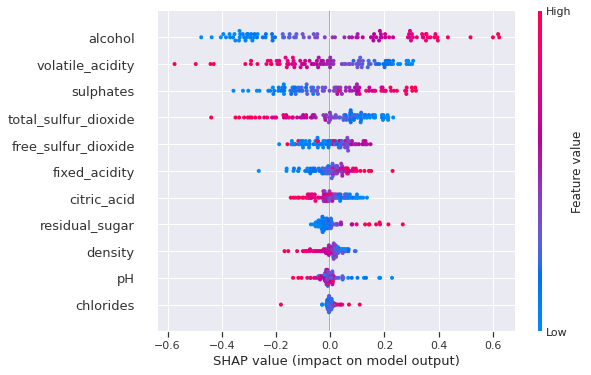

In [ ]:
# SHAP summary for Linear Model
shap.summary_plot(svm_shap_values, x_train_100)

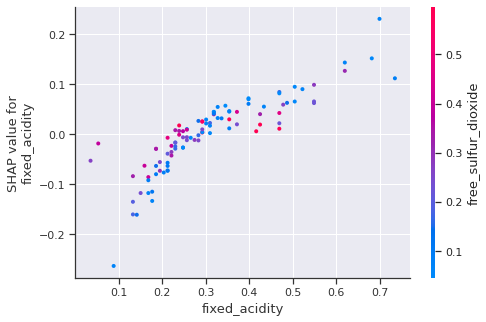

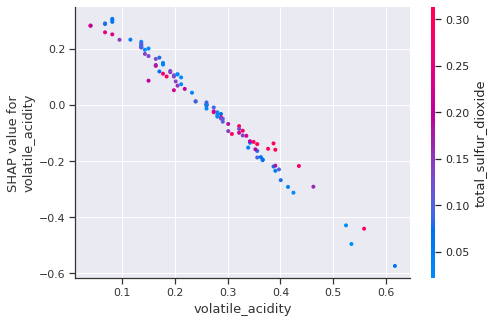

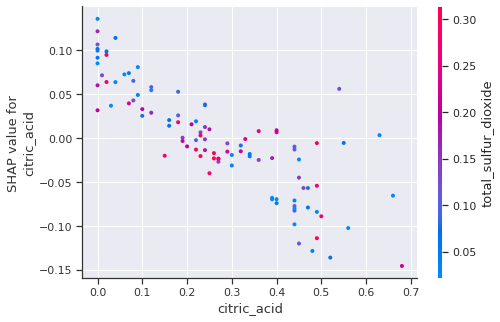

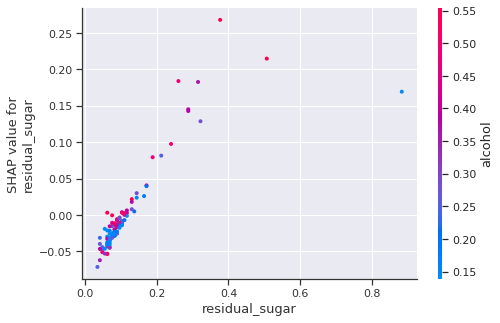

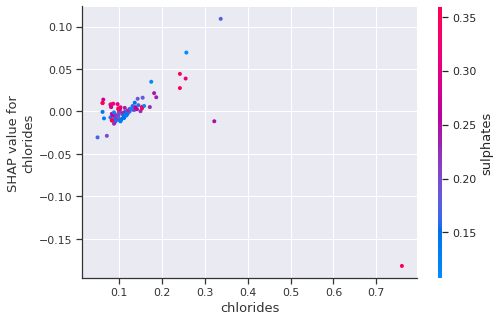

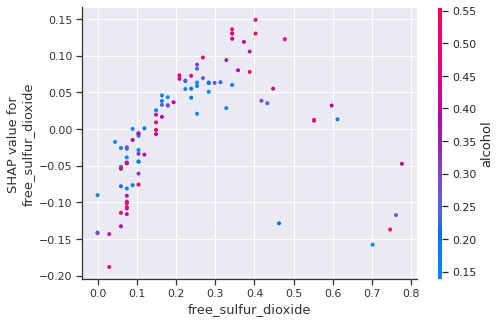

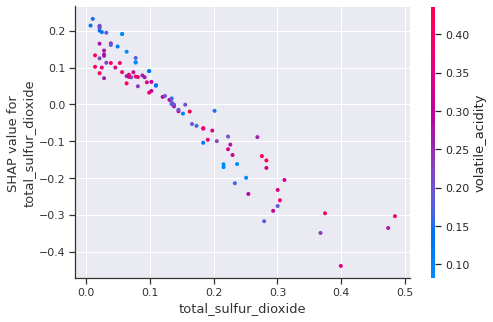

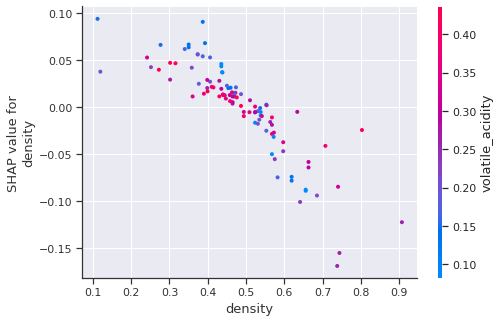

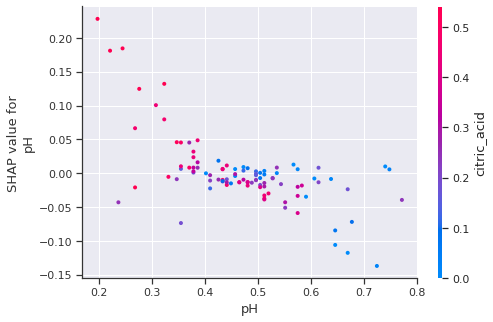

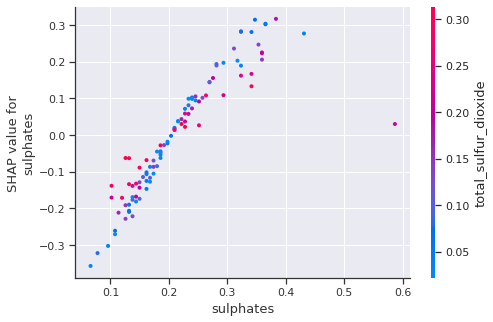

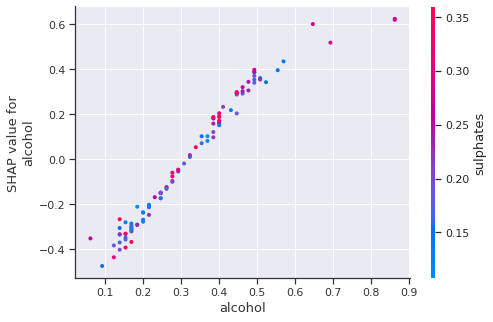

In [ ]:
# SHAP partial dependence plot for a tree based model
for i in x_train.columns:
    shap.dependence_plot(i, svm_shap_values.values, x_train_100)

###Heatmap Visualization for Linear and Tree-based model

- This visualization is a summarization of the entire dataset on how each data point in every feature is affecting the target(quality of wine). 
  - Here the Y-axis is Features
  - and X-axis is Instance of that feature
  - The color of the instance defines if it had a positive effect or negative effect by its color. If the instance is red then it had a positive effect and if the instance is blue then it had a negative effect
  - The intensity of the color is directly proportional to the intensity of the effect. Deeper the color, the more impactful the feature is

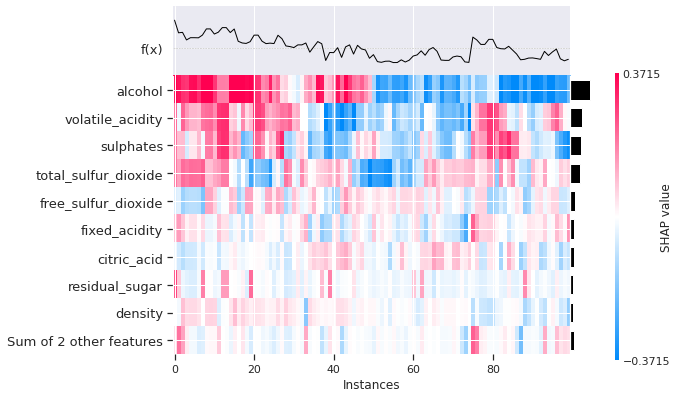

In [ ]:
shap.plots.heatmap(svm_shap_values)  # SHAP HeatMap of a Tree Based Model

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


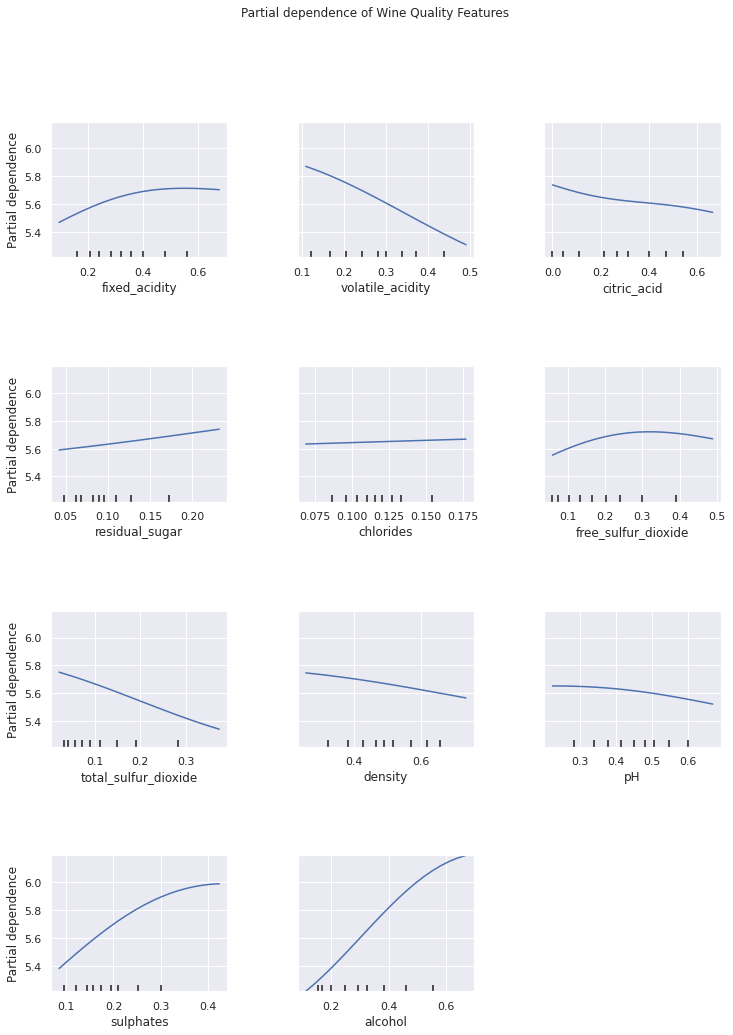

In [ ]:
# PDP Plot for Tree based Model
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(svm_model, x_test, x_test.columns, n_jobs=3, grid_resolution=20)


fig = plt.gcf()
plt.rcParams["figure.figsize"] = (20, 10)
fig.suptitle("Partial dependence of Wine Quality Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.rcParams["figure.figsize"] = (32, 24)
plt.show()

# Interpreting AutoML's best model with tuned hyperparameters
### How are errors/residuals distributed and how interpretable is your model ?
**Residual Analysis**
- Here, we can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. It can also be observed from the below graph that residuals are normally distributed. Residuals signify that residuals don't have heteroscedasticity.

**Variable Importance**
- In the variable importance plot we can observe that the plot replicates the results which we got from the Linear Model and Tree-Based Model above. The variable importance has been scaled between 0 to 1 for ease of understanding

**SHAP Summary**
- From the SHAP summary diagram, we can interpret a few conclusions - 

  1.   All the features are listed as per their importance in making the prediction, that is alcohol is more significant followed by volatile_acidity, and so on. Hence, free_sulphur_dioxide is the least significant predictor in our model.
  2.   The position on the SHAP value axis indicates the impact the feature has on the prediction either positive or negative. That is, the more the data point is away from the 0.0 shap value - the more its impact is. As we can see Alcohol has the most impact on the quality of the wine. The color of the dot represents (Red - High, Blue - Low) the impact of the value on the result. i.e. - Hight amount of alcohol results in high quality of wine, a low amount of volatile acidity results in high quality of wine, and so on. As we can see the distribution of red points in the Alcohol feature is far more spread than the blue points. From this visual, we can interpret that the quality of wine vastly increases as the amount of alcohol increases. It doesn't have much impact if the content is low i.e. between the shap value of 0.4 to 0.6 the blue data points are pretty concentrated. Inversely for the Volatile Acidity, less is better for the quality of the wine. Let us analyze the distribution of SHAP values of this feature. As seen in the SHAP plot we can see that extreme values on both ends can have a significant effect on the quality of the wine. 


- The advantage of SHAP analysis over normal feature importance is that we could visualize how the feature is affecting the target at different values. The standard methods tend to overestimate the importance of continuous or high-cardinality categorical variables.

**Partial Dependence Plot (PDP)**

- A partial dependence plot shows the marginal effect of a feature on the target(wine quality in our dataset). It is achieved by keeping all other variables constant and changing the value of one variable to get its PDP. For Interpretation purposes, let us pick up the two most important variables - Alcohol and Sulphate. 

  1.   As we can see that when the rest of the variables are kept constant and a marginal change is made in alcohol, we can see the mean response increases between alcohol levels of 11 and 12. This could be interpreted as this range of alcohol could be the deciding factor in the quality of the wine.
  2.   Similarly when the rest of the variables are kept constant and a marginal change is made in sulfate we can observe the mean response of quality going up between the sulfate range of 0.4 to 0.8. Hence, it can be interpreted that this range is deciding factor in the quality of the wine. 

- The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

**ICE (Individual Conditional Expectation) Plot**
- ICE plot is similar to what we did in the PDP plot, but the fundamental difference between the two methods is that the PDP plot focuses on the average effect of a feature and does not focus on a specific instance. ICE plot comes in rescue to address this drawback of the PDP plot where the outputs from all instances are considered instead of an average value. 

- Let us go back to the alcohol and sulfate features, as we interpreted in PDP the quality of wine increases when alcohol and sulfate value is between 11 to 12 and 0.4 to 0.8 respectively. But is this true for every wine in the dataset? ICE plot has an answer to this question. As we can see in the ICE plot above the quality of a few wines(0th percentile instance) increases a lot in this range while the quality of a few doesn't change much(100th Percentile Instance). 

- Individual conditional expectation curves are even more intuitive to understand than partial dependence plots. One line represents the predictions for one instance if we vary the feature of interest.



# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

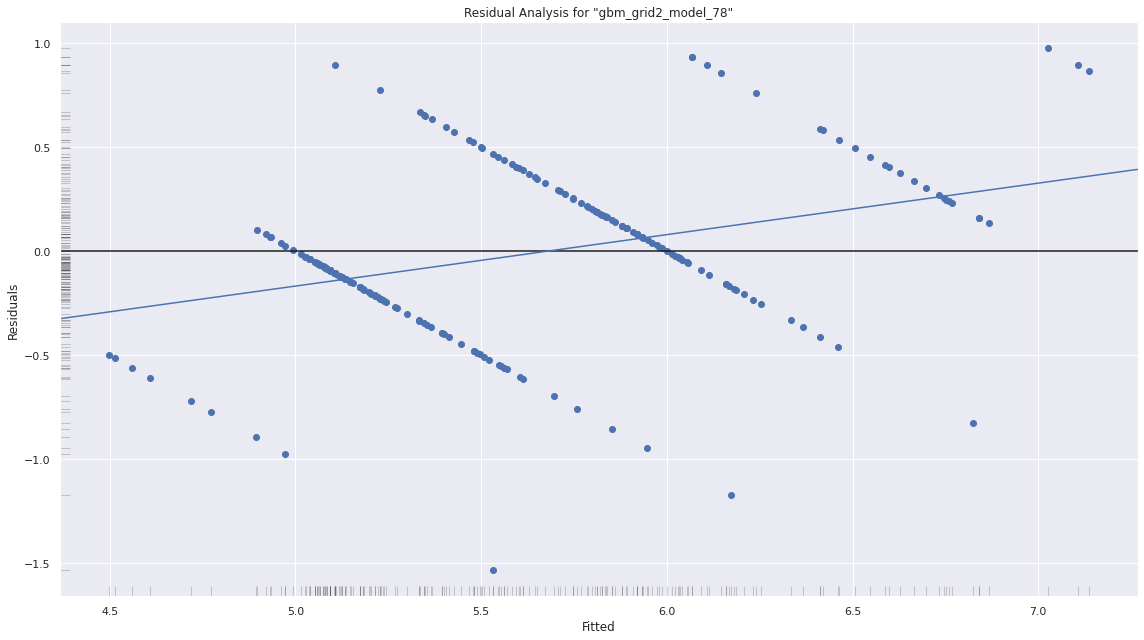

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

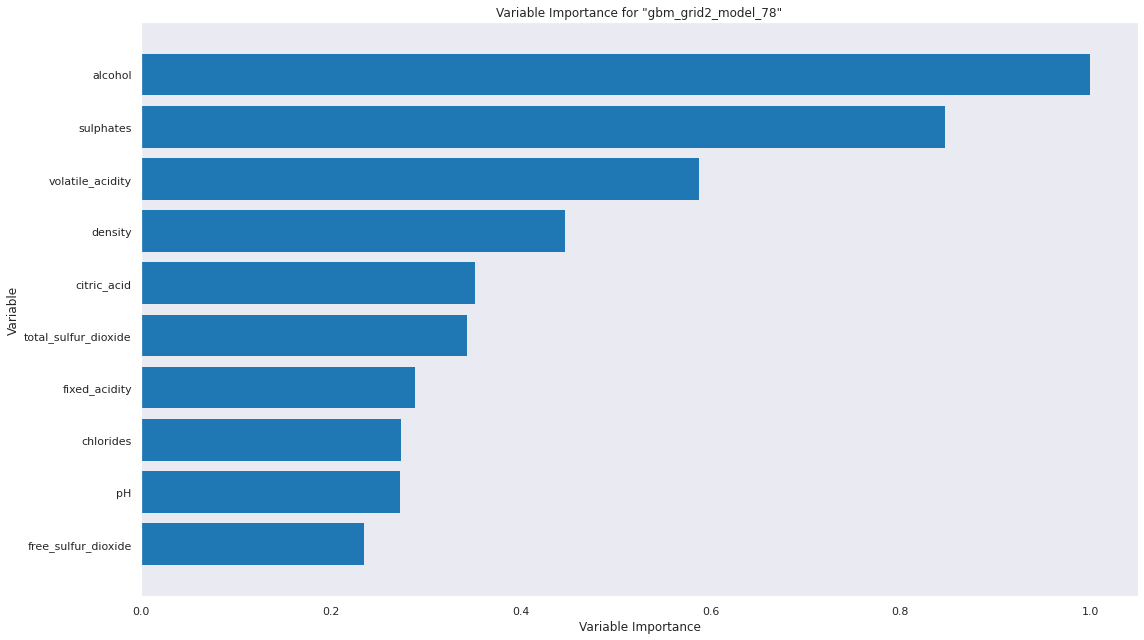

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

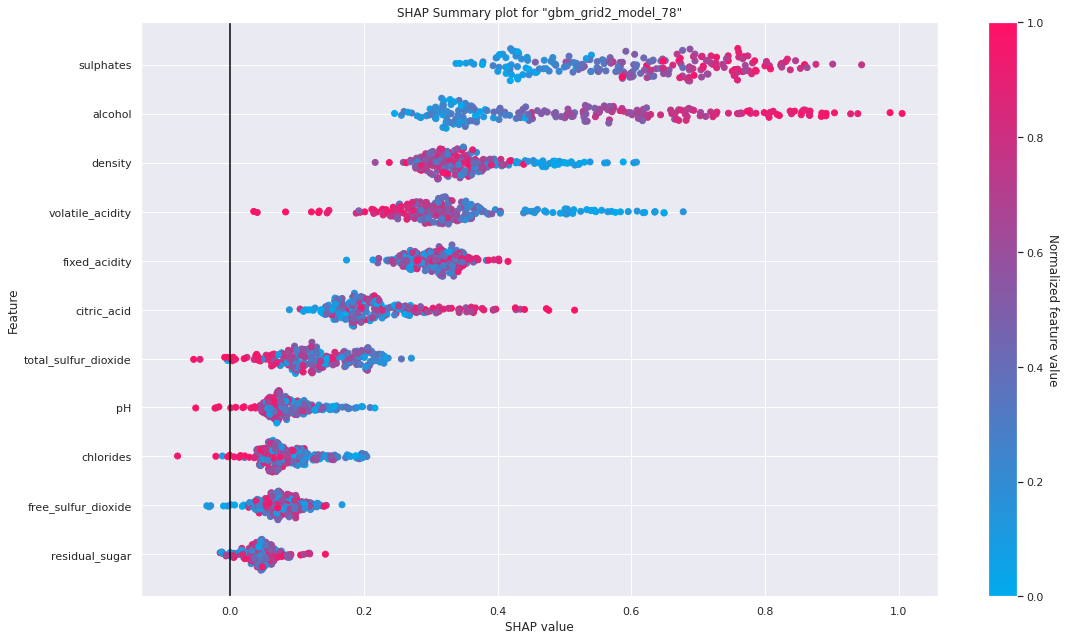

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

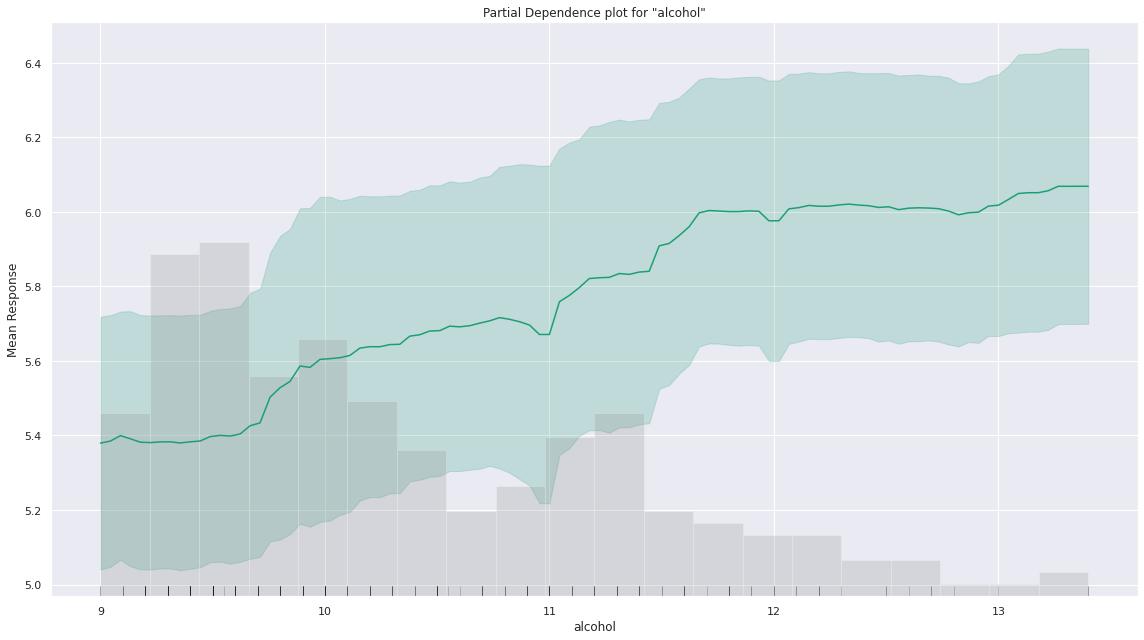

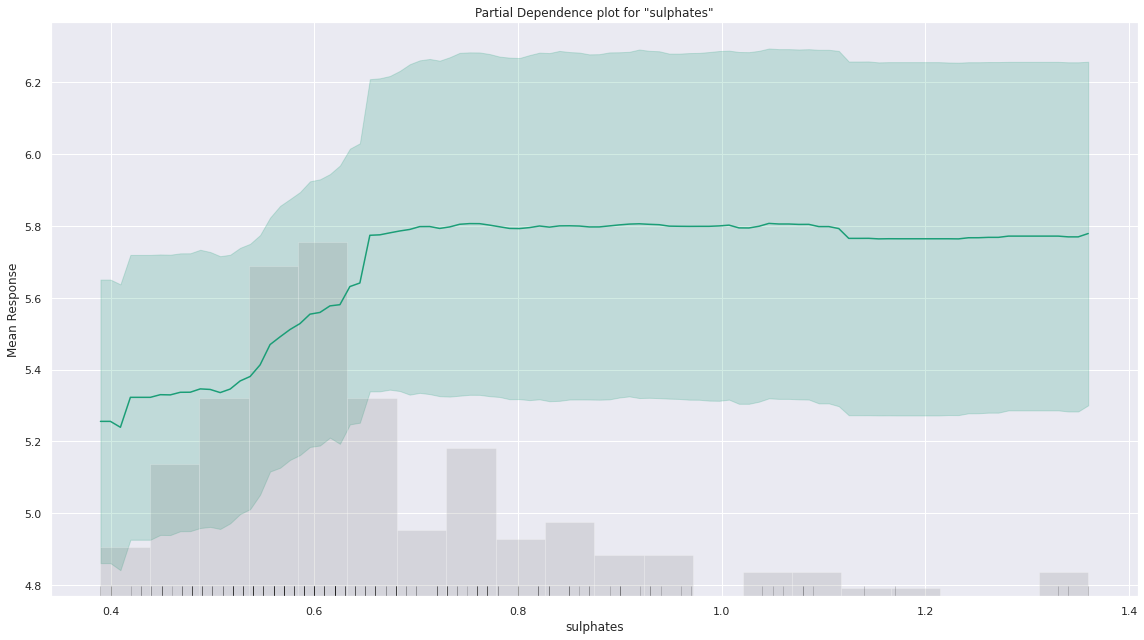

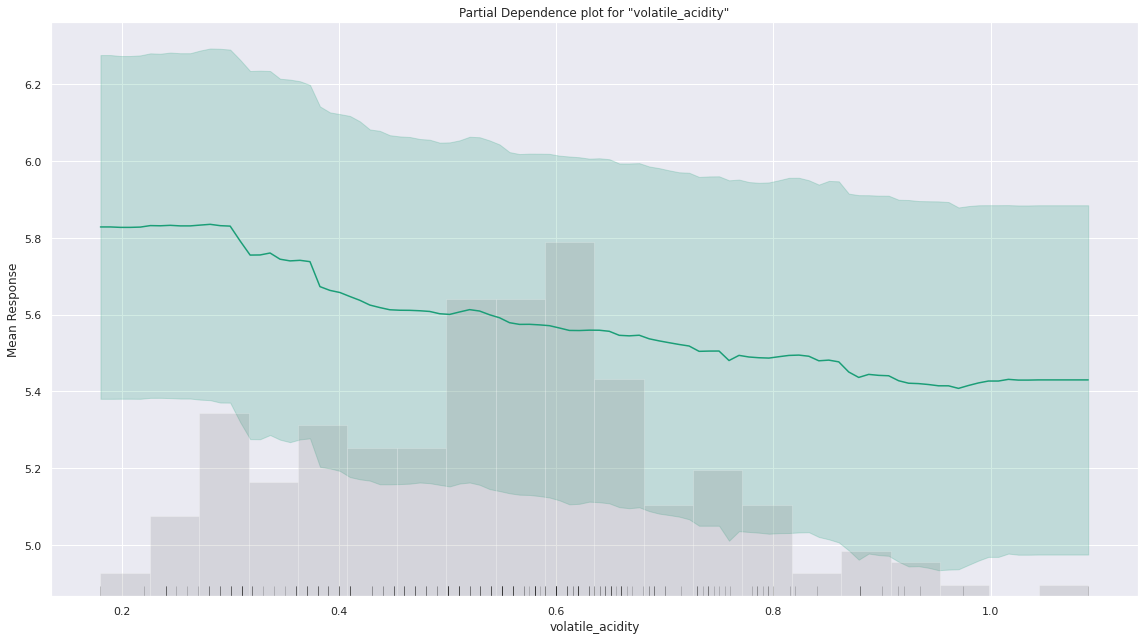

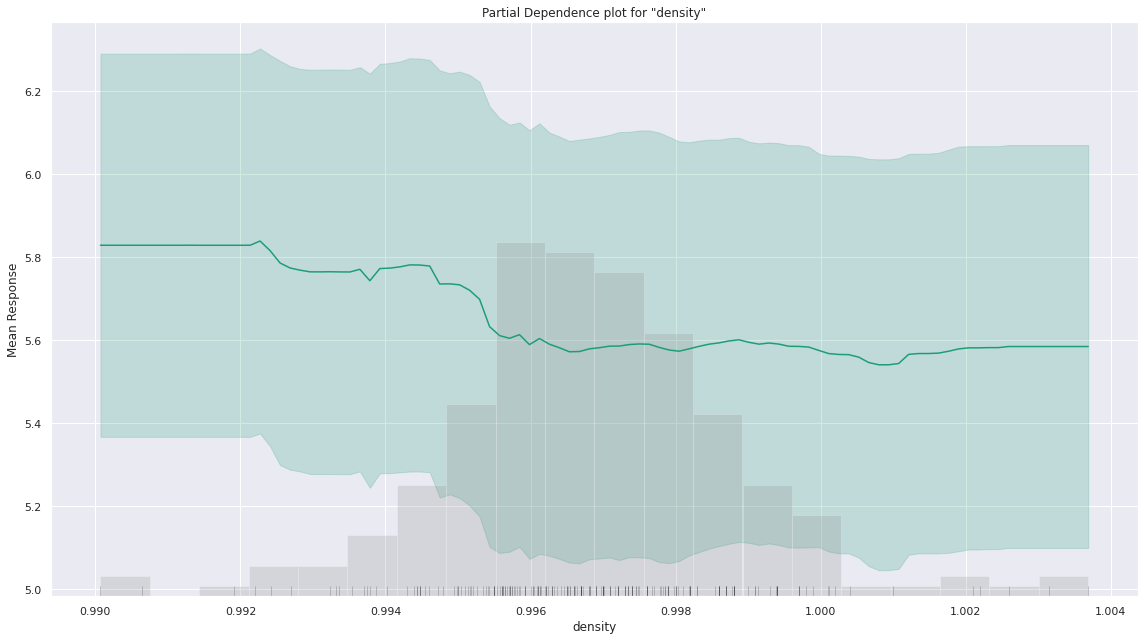

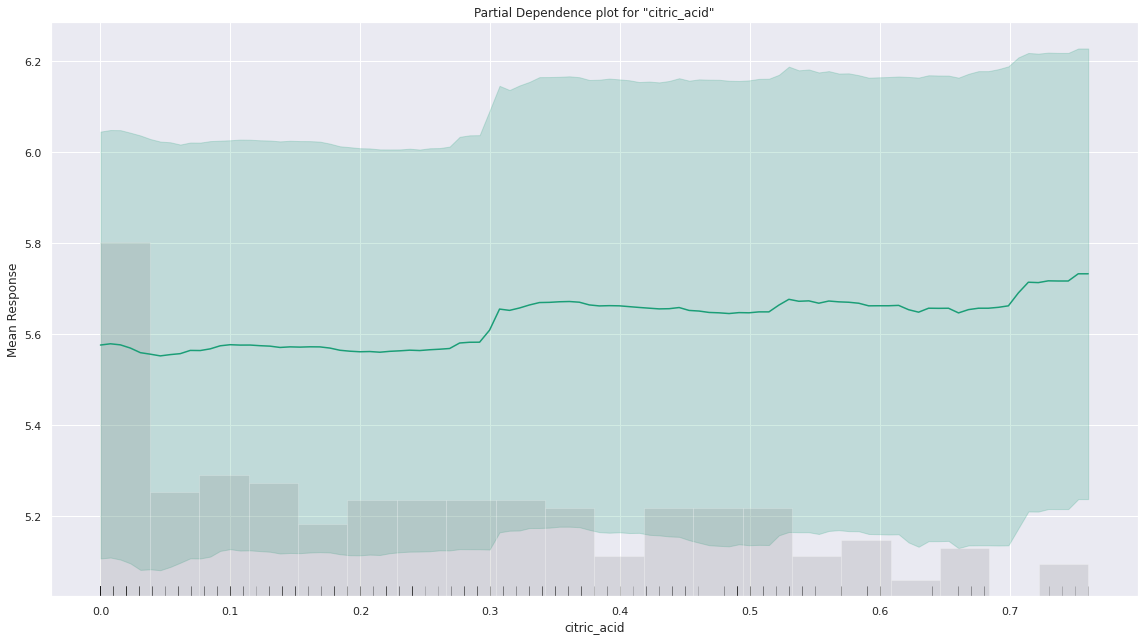

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

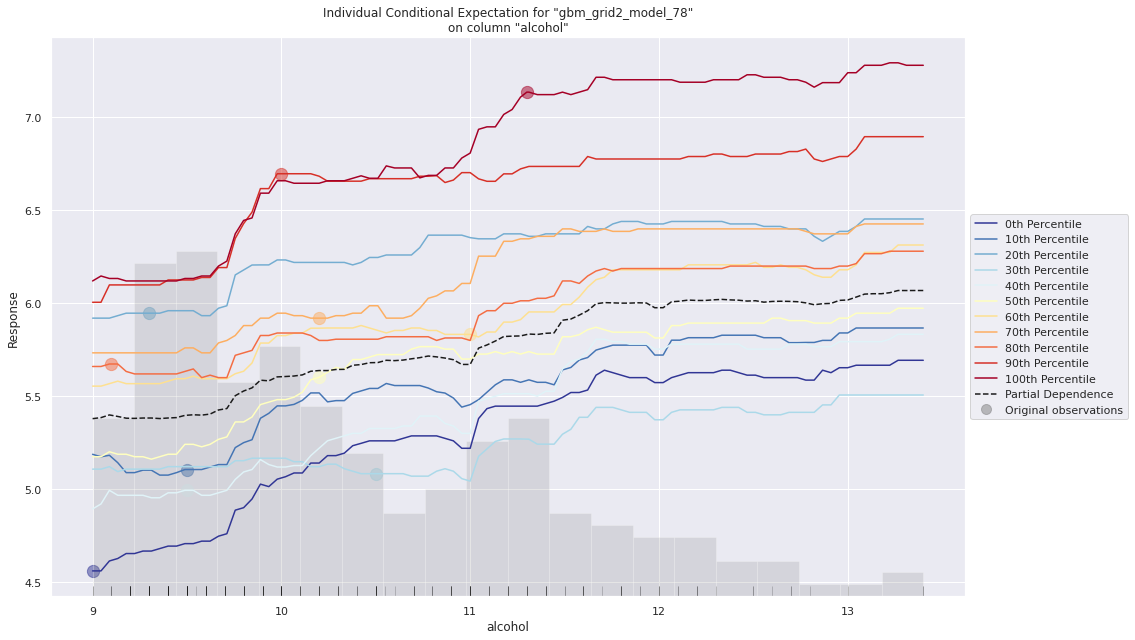

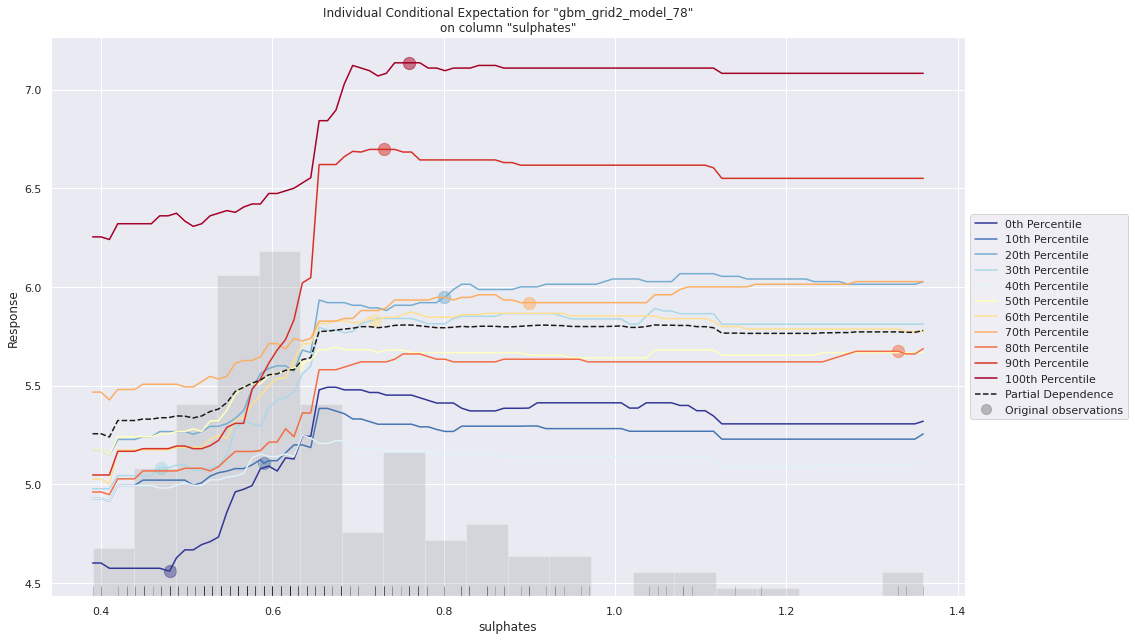

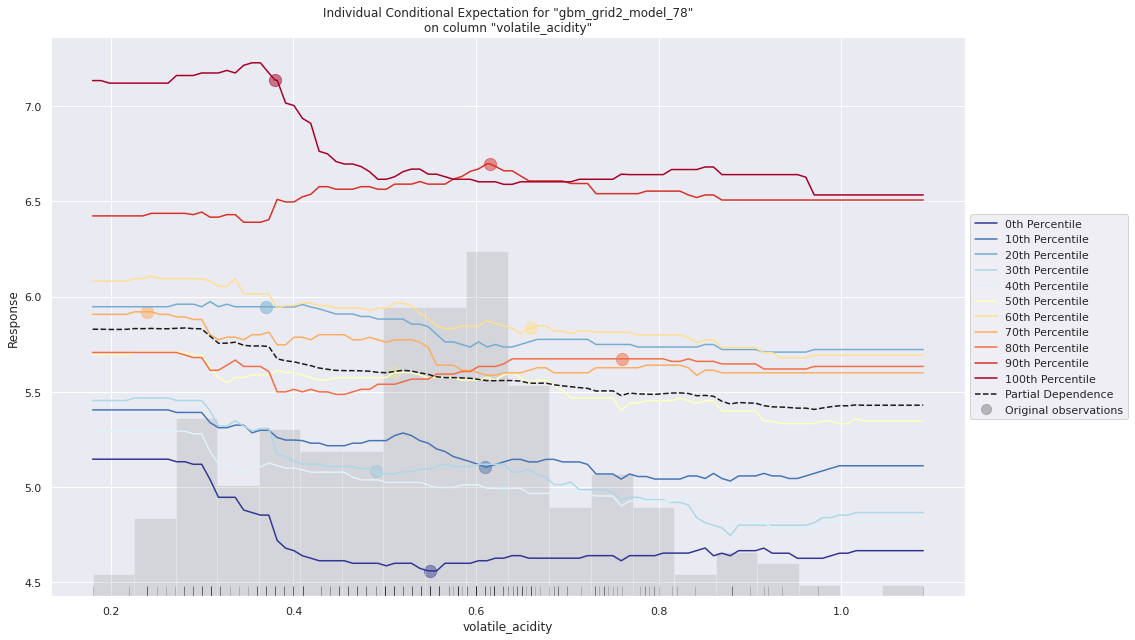

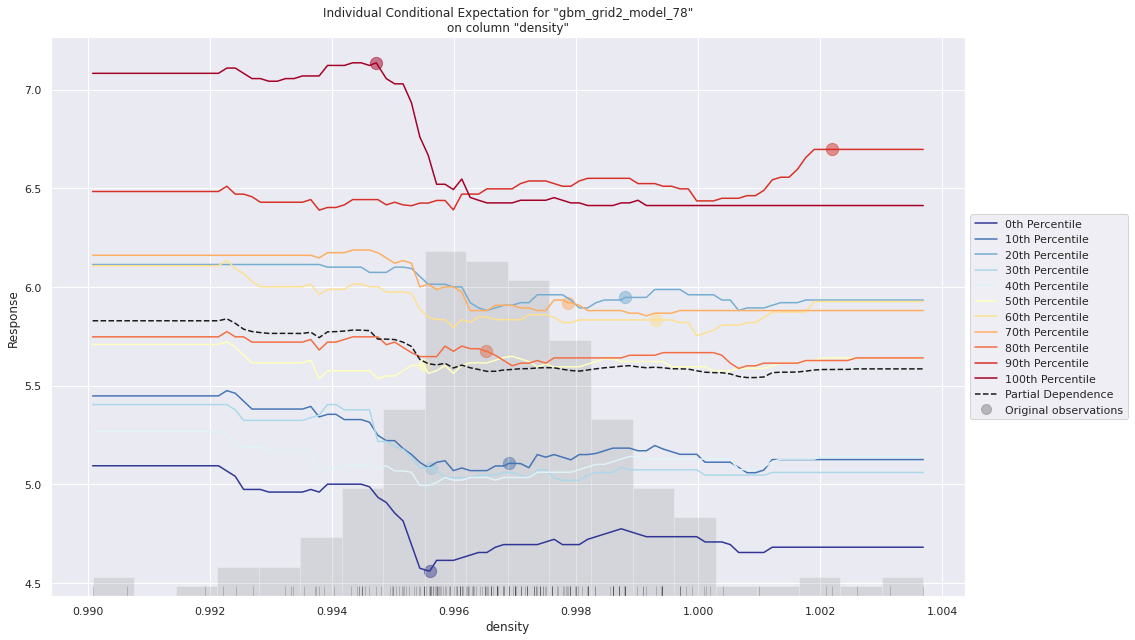

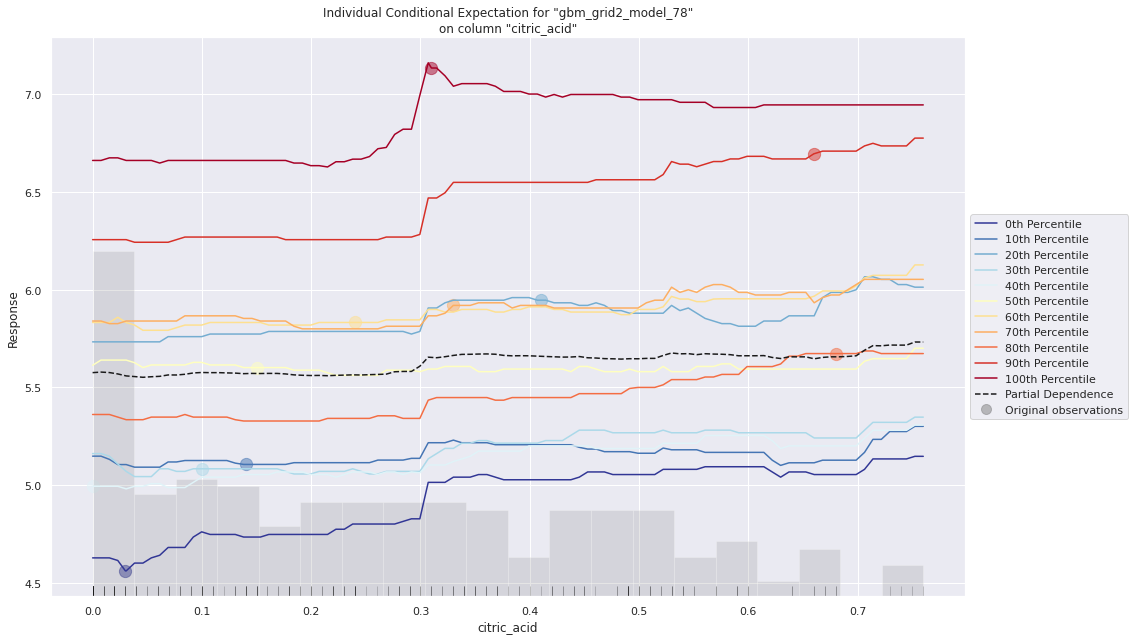

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [ ]:
best_drf_model.explain(autoML[1])  # AutoML Explainability

### Final Takeaways
- The AutoML's best model with its Hyperparameter's tuned is the best model for this task as it has the highest accuracy compared to the other models tested in this excercise. Also, this model is interpretible i.e. we can actually get to the root of what made this prediction to come to. 

### Learning Outcomes
- I learned the complete lifecycle of a Data Science project right from data prepartion to hyperparameter tuning
- Majority of the time should be invested in data preparation i.e. cleaning the data, normalizing, feature selection, imputation etc
- Hyperparameter tuning is the second most important thing after data preparation, which most of the practioner's ignore. But the results are worth the time invested
- Multiple models must be trained and the best models should be selected to be deployed, as some algorithms perform much better than the other's on specific tasks
- Model Interpretation(Unboxing the Black Blox) is the best takeaway from the series of this assignments. SHAP, LIME and PDP have made it easier to understand what made a model to predict a outcome.


# References
- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html
- https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
